In [1]:
%pylab inline



import scipy.stats

import pyspark
sc = pyspark.SparkContext()


Populating the interactive namespace from numpy and matplotlib


# Model Definition

In [2]:
# parameters specifying the probability model: 
#  boundaries of the world, 
#  locations of stations,
#  event rate,
#  arrival time distribution,
#  and signal properties


# "hard" setting: larger world
event_rate = 0.020
start_time = 0.0
end_time = 240
# end_time = 480
timespan = end_time-start_time

xmin = 0.0
xmax = 100.0
station_locs = [0.0, 33.0, 66.0, 100.0]
n_stations = len(station_locs)

wave_velocity = 2.0
#MAX_TRAVEL_TIME = int((xmax-xmin)/wave_velocity)
# Smaller world, the uncertainty of arrival cannot be ignored 50 + 3*3.2 ~ 59.6
arrival_time_stddev = 3.0
MAX_TRAVEL_TIME = int((xmax-xmin)/wave_velocity) + arrival_time_stddev*3.2
region_length = MAX_TRAVEL_TIME

station_noise_stddev = [1.0, 1.0, 1.0, 1.0, 1.0]
event_signal_stddev = 4.0
signal_duration = 10.0

In [3]:
# Code to sample a world from the model (i.e., from the prior distribution on worlds).


def station_stddev(i, events):
    # helper function to compute signal probabilities. 
    # given:
    #  i: station index
    #  events: matrix representing an event hypothesis (see generate_from_prior)
    # return 
    #  s: vector of the same length as the signal at s, giving the stddev of the
    #     signal at each timestep.
    s = np.ones(int(timespan+MAX_TRAVEL_TIME)) * station_noise_stddev[i]**2

    for ev in events:
        station_arrival_time = ev[i+2]
        arrival_start_idx = max(start_time, int(station_arrival_time))
        arrival_end_idx = min(end_time+MAX_TRAVEL_TIME, int(station_arrival_time + signal_duration))
        if arrival_start_idx > (end_time+MAX_TRAVEL_TIME) or arrival_end_idx < start_time or arrival_end_idx <= arrival_start_idx: 
            continue
        arrival_len = arrival_end_idx - arrival_start_idx

        s[arrival_start_idx:arrival_end_idx] += event_signal_stddev**2         
    return np.sqrt(s)

def sample_event_from_prior():
    import scipy.stats
    # sample from the prior distribution on an event's time, location, and arrival times at all stations
    t_origin = float(scipy.stats.uniform(start_time, scale=timespan).rvs(1))
    x_origin = float(scipy.stats.uniform(xmin, scale=(xmax-xmin)).rvs(1))
    event_state = [t_origin, x_origin]

    # and sample the arrival time at each station
    for x_station in station_locs:
        arrival_time_mean = t_origin + np.abs(x_station-x_origin)/wave_velocity
        arrival_time = float(scipy.stats.norm(arrival_time_mean, arrival_time_stddev).rvs(1))
        event_state.append(arrival_time)
    return event_state

def sample_event_given_timerange(time_space):
    # sample from the prior distribution on an event's time, location, and arrival times at all stations
    import scipy.stats
    t_origin = float(scipy.stats.uniform(time_space[0], scale=time_space[1]-time_space[0]).rvs(1))
    x_origin = float(scipy.stats.uniform(xmin, scale=(xmax-xmin)).rvs(1))
    event_state = [t_origin, x_origin]

    # and sample the arrival time at each station
    for x_station in station_locs:
        arrival_time_mean = t_origin + np.abs(x_station-x_origin)/wave_velocity
        arrival_time = float(scipy.stats.norm(arrival_time_mean, arrival_time_stddev).rvs(1))
        event_state.append(arrival_time)
    return event_state

def sample_world_from_prior():
    import scipy.stats
    # sample the number of events from a Poisson prior
    n_events = scipy.stats.poisson(event_rate * timespan).rvs(1)
    
    # for each event, sample an origin time and location uniformly at random
    sampled_events = []
    for i in range(n_events):
        event_state = sample_event_from_prior()
        sampled_events.append(event_state)

    # represent event state as a matrix:
    #  - each row is a different event
    #  - columns 0 and 1 are origin time and location
    #  - for i >= 0, column i+2 is the arrival time at station i
    sampled_events = np.asarray(sampled_events)
    
    # sample the signals generated at each station
    signals = []
    for i in range(n_stations):
        # sample background noise at each station
        s = station_stddev(i, sampled_events)
        signal = np.random.randn(len(s)) * s
        signals.append(signal)
    
    return sampled_events, signals

# For testing purpose: given event location and time, event state: [t_origin, x_origin]
# sample arrival time/ signals
def sample_signal_given_test_events(event_states):
    import scipy.stats
    for event_state in event_states:
    # and sample the arrival time at each station
        for x_station in station_locs:
            arrival_time_mean = event_state[0] + np.abs(x_station-event_state[1])/wave_velocity
            arrival_time = float(scipy.stats.norm(arrival_time_mean, arrival_time_stddev).rvs(1))
            event_state.append(arrival_time)
    
    sampled_events = np.asarray(event_states)     
    signals = []
    for i in range(n_stations):
        # sample background noise at each station
        s = station_stddev(i, sampled_events)
        signal = np.random.randn(len(s)) * s
        signals.append(signal)
    
    return  sampled_events, signals

In [4]:
# Code to compute probabilities of worlds under the model

def arrival_time_logp(event):
    import scipy.stats
    # helper function to compute the log probability of an event's arrival times,
    # given the origin location.
    atime_lp = 0
    t_origin, x_origin = event[0], event[1]
    for i, x_station in enumerate(station_locs):            
        arrival_time_mean = t_origin + np.abs(x_station-x_origin)/wave_velocity
        arrival_time_observed = event[i+2]
        atime_lp += float(scipy.stats.norm(arrival_time_mean, arrival_time_stddev).logpdf(arrival_time_observed))
    return atime_lp

# compute the (log) probability density of a possible world
def logp(events, signals, temper=1.0):

    # events out of bounds have zero probability under the model
    n_events = events.shape[0]
    if n_events > 0 and ((events[:, 0] < start_time).any() or (events[:, 0] > end_time).any()):
        return -np.inf
    if n_events > 0 and ((events[:, 1] < xmin).any() or (events[:, 1] > xmax).any()):
        return -np.inf
    
    # log probability of n events, with uniform arrival times, under
    # a Poisson process.
    # equal to log( Poisson(n_events; event_rate) * (1/timespan)**(n_events) * factorial(n_events) )
    # where the factorial comes from summing over the number of events. 
    ev_prior_lp = n_events * np.log(event_rate) - (event_rate * timespan)
    
    # probability of event locations under a uniform prior
    ev_prior_lp += n_events - np.log((xmax-xmin))

    # probability of arrival times under the arrival-time model
    atime_lp = 0
    for event in events:
        atime_lp += arrival_time_logp(event)
        
            
    # probability of signals, given the hypothesized arrival times
    signal_lp = 0
    for i in range(n_stations):
        s = station_stddev(i, events)
        # probability of the signal under an iid Gaussian model.
        # equiv to 
        # signal_lp += np.sum([scipy.stats.norm(scale=s[j]).logpdf(signals[i][j]) for j in range(len(s))])
        # but to save computation we write out the Gaussian density explicitly
        scaled_signal = signals[i]/s
        gaussian_lp = -.5*np.dot(scaled_signal, scaled_signal)
        gaussian_lp += -np.sum(np.log(s)) - .5*len(s)*np.log(2*np.pi)
        signal_lp += gaussian_lp
        
    lp = ev_prior_lp + atime_lp + signal_lp
    return lp

# Visualization

In [5]:

def visualize_samples(samples=None, true_events=None, region_length = None):
    width = 5
    height = width * (timespan / (xmax-xmin))
    f = figure(figsize=(width, height))
    ax = f.add_subplot(111)
    
    if true_events is not None:
        ax.scatter(true_events[:, 1], true_events[:, 0], alpha=1.0, s=40, marker="*", color="red")
    
    if samples is not None:
        n_samples = len(samples)
        for events in samples:
            if events.shape[0] == 0: continue
            #ax.scatter(events[:, 1], events[:, 0], alpha=1.0/np.sqrt(n_samples), s=2)
            ax.scatter(events[:, 1], events[:, 0], alpha=1.0/100, s=2)

    
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((start_time, end_time))
    
    for x_station in station_locs:
        ax.axvline(x_station, c='green')
           
    if region_length is not None:
        region_num = end_time / region_length 
        for i in range(int(region_num)):
            ax.axhline((i+1)* region_length, c='green') 
            ax.axhline(start_time, c = 'green')
            ax.axhline(end_time, c = 'green')
        
def visualize_signals(events, signals):
    for i in range(n_stations):
        s = station_stddev(i, events)
        f = figure(figsize(20, 5))
        ax = f.add_subplot(121)
        ax.plot(signals[i])
        ax.plot(s, c="red")
        ax.set_title("signal at station %d, x=%.1f" % (i, station_locs[i]))
        
def visualize_prediction(prediction=None, true_events=None, matchings = None, left_prediction = None, left_true_events = None, region_length = None):
    width = 5
    height = width * (timespan / (xmax-xmin))
    f = figure(figsize=(width, height))
    ax = f.add_subplot(111)
    
    if true_events is not None:
        ax.scatter(true_events[:, 1], true_events[:, 0], alpha=1.0, s=40, marker="*", color="red")
    
    if prediction is not None:
        for event in prediction:
            ax.scatter(event[1], event[0], alpha= 0.5, s=3, marker="*")
 
    if matchings is not None:
        for matching in matchings:
            x = [matching[0][1], matching[1][1]]
            y = [matching[0][0], matching[1][0]]
            ax.plot(x, y, alpha = 0.4, linewidth = 0.12, color = 'black')
            
    if left_prediction is not None:
        for event in left_prediction: 
            ax.scatter(event[1], event[0], alpha=0.5, s=3, marker="*", color = 'purple')
    
    if left_true_events is not None:
        for event in left_true_events:
            ax.scatter(event[1], event[0], alpha=0.1, s=40, marker="*", color="orange")
        
    ax.set_xlabel("$x$")
    ax.set_ylabel("$t$")
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((start_time, end_time))
    
    for x_station in station_locs:
        ax.axvline(x_station, c='green')
           
    if region_length is not None:
        region_num = end_time / region_length 
        for i in range(int(region_num)):
            ax.axhline((i+1)* region_length, c='green') 
            ax.axhline(start_time, c = 'green')
            ax.axhline(end_time, c = 'green')


sampled 7 events
[[  79.55292065   75.25929928  118.97182276  100.95345285   86.00251702
    96.5376628 ]
 [  60.52177912   86.18741253  105.52395682   88.18612222   69.93946016
    73.81350549]
 [ 106.06242024   63.51385001  132.88301276  123.35158652  107.37219474
   123.22252242]
 [  42.0223424    63.33645616   75.69636267   57.41896426   40.7881265
    62.82927195]
 [  28.87174705   23.12915172   40.46398424   33.58894862   45.68617378
    69.54642875]
 [ 232.11735604   40.05941749  251.6331298   235.54546855  246.79011773
   266.85387359]
 [ 197.29428275   44.27238852  213.96419356  202.57910812  209.34334679
   225.14346315]]
log density -2167.59481392


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


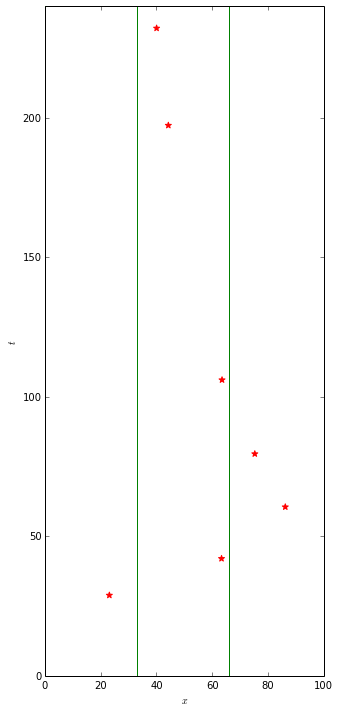

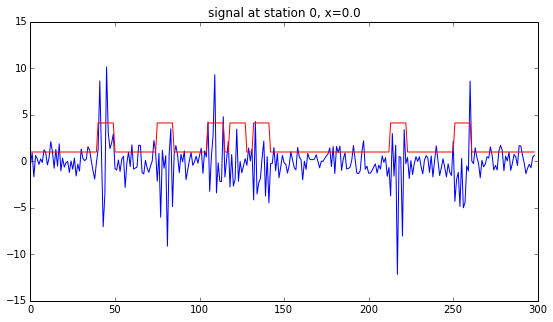

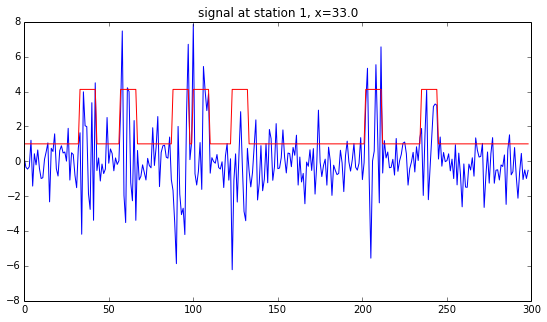

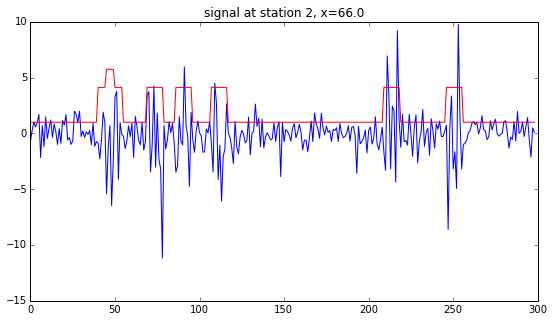

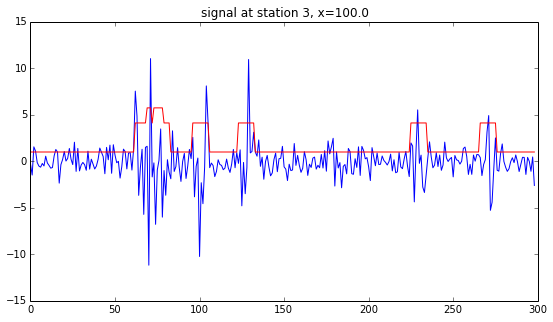

In [6]:
# sample a world from the model, 
# compute its log probability density,
# and visualize the events and the generated signals

sampled_events, signals = sample_world_from_prior()
print "sampled %d events" % len(sampled_events)
print sampled_events
print "log density", logp(sampled_events, signals)
visualize_samples(samples=None, true_events=sampled_events)
visualize_signals(sampled_events, signals)

#  Performance Evaluation For All

In [8]:
import math
import random

import math

import math

def performance_evaluate(mh_samples, true_events):
    all_predictions = [] # all predictions of 100 random samples
    all_matchings = []
    all_left_predictions = []
    all_left_true_events = []
    all_precisions = []
    all_recalls = []
    all_error = 0
    # take 100 random samples from samples after 90% steps (stable)
    
    
    if (0.1*len(mh_samples) < 100):
        sample_num = int(0.1*len(mh_samples))
        events_idx = random.sample(range(int(len(mh_samples)*0.9), len(mh_samples)), int(0.1*len(mh_samples)))
    else:
        sample_num = 100
        events_idx = random.sample(range(int(len(mh_samples)*0.9), len(mh_samples)), 100)
        
        
    for i in range(len(events_idx)):
        idx = events_idx[i]
        prediction = []
        prediction.extend(mh_samples[idx].tolist())
        
        prediction_copy = list(prediction)
        left_true_events = []
        matchings = []
        error_one_sample = 0
        for event in true_events:
            min_error = float('inf')
            best_predict = None
            if len(prediction_copy) != 0:
                for pred in prediction_copy:
                    temp_error = math.pow((event[0] - pred[0]),2) + math.pow((event[1] - pred[1]),2)
                    if temp_error < min_error:
                        min_error = temp_error
                        best_predict = pred
                ## ADD threshold, 1.0 is event_loc move std
                if abs(event[0] - best_predict[0]) < 12.0 and abs(event[1] - best_predict[1]) < 12.0:
                    matchings.append([event.tolist(), best_predict])
                    prediction_copy.remove(best_predict)
                    error_one_sample += min_error
                else:
                    left_true_events.append(event)
            else:
                left_true_events.append(event)
        left_prediction = prediction_copy
        all_predictions.extend(prediction)
        all_matchings.extend(matchings)
        all_left_predictions.extend(left_prediction)
        all_left_true_events.extend(left_true_events)
        if len(prediction) == 0:
            all_precisions.append(1.0)
        else:
            all_precisions.append((len(prediction) - len(left_prediction))/float(len(prediction)))
        if len(true_events) == 0:
            all_recalls.append(1.0)
        else:
            all_recalls.append((len(true_events) - len(left_true_events))/float(len(true_events)))
        if len(matchings) != 0:
            all_error += (error_one_sample/sample_num)/len(matchings)
    average_precision = mean(all_precisions)
    average_recall = mean(all_recalls)
    return all_predictions, all_matchings, all_left_predictions, all_left_true_events, all_error, average_precision, average_recall

# predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(all_samples, sampled_events)

# blue, red, blue_region_num, red_region_num, region_length = build_region()
# visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, region_length)
# print error, precision, recall


def logp_evaluate(mh_samples, signals):
    import matplotlib.pyplot as plt 
    lps = []
    for sample in mh_samples:
        lps.append(logp(sample, signals))
    return lps



# Visualize helper for all Parallels

In [9]:
# WARNING: densities are not comparable between worlds with different numbers of events!
import matplotlib.pyplot as plt

for lps in region_lps: # log proba in each region
    plt.plot(lps)
    print len(lps)
    plt.show()

blue, red, blue_region_num, red_region_num, proposal_stddev, out_of_bound_range, region_length = build_region()
visualize_samples(all_samples, sampled_events, region_length)
visualize_signals(all_samples[-1], signals)

NameError: name 'region_lps' is not defined

# Base moves, inference function for all Parallels

In [9]:
import random
def event_loc_move_parallel(events, region, proposal_stddev = 1.0):
    # MH proposal: move a random event by a Gaussian offset in space and time
    n_events = events.shape[0]
    if n_events == 0:
        return events, 0.0, 0.0, False
    
    event_idx = np.random.choice(np.arange(n_events))
    proposed_events = events.copy()
    
    proposed_events[event_idx, :2] += np.random.randn(2) * proposal_stddev
    # automatically reject when out of bound
    if proposed_events[event_idx, 0] >= region[1] or proposed_events[event_idx, 0] <= region[0]:
        return proposed_events, 0.0, 0.0, True
    else:
        return proposed_events, 0.0, 0.0, False
    
def multi_event_loc_move_parallel(events, region, proposal_stddev = 1.0):
    n_events = events.shape[0]
    if n_events == 0 or n_events == 1:
        return events, 0.0, 0.0, False

    events_idx = random.sample(range(0, n_events), 2)
    t1 = events[events_idx[0], 0]
    x1 = events[events_idx[0], 1]
    t2 = events[events_idx[1], 0]
    x2 = events[events_idx[1], 1]
    # find matching pair
    t1_match = (t1 + t2)/2.0 + ((x2 - x1)/2.0)/wave_velocity
    x1_match = wave_velocity*(t2 - t1)/2.0 + (x1 + x2)/2.0
    
    t2_match = (t1 + t2)/2.0 + ((x1 - x2)/2.0)/wave_velocity
    x2_match = wave_velocity*(t1 - t2)/2.0 + (x1 + x2)/2.0
    
    proposed_events = events.copy()
    states = [[t1_match, x1_match], [t2_match, x2_match]]
    matches, signals = sample_signal_given_test_events(states)
    
    proposed_events[events_idx[0]] = matches[0]
    proposed_events[events_idx[1]] = matches[1]
#     proposed_events[events_idx[0], 0] = t1_match 
#     proposed_events[events_idx[0], 1] = x1_match 
#     proposed_events[events_idx[1], 0] = t2_match 
#     proposed_events[events_idx[1], 1] = x2_match 
    
#     # swapping arrival times
#     for i in range(n_stations):
#         if x1_match > station_locs[i]:
#             proposed_events[events_idx[0], i + 2] = events[events_idx[1], i + 2]
#         else:
#             proposed_events[events_idx[0], i + 2] = events[events_idx[0], i + 2]
            
#         if x2_match > station_locs[i]:
#             proposed_events[events_idx[1], i + 2] = events[events_idx[0], i + 2]
#         else:
#             proposed_events[events_idx[1], i + 2] = events[events_idx[1], i + 2]
    
    # automatically reject when out of bound
    if t1_match >= region[1] or t1_match <= region[0] or t2_match >= region[1] or t2_match <= region[0]:
        return proposed_events, 0.0, 0.0, True
    else:
        return proposed_events, 0.0, 0.0, False

def atime_move_parallel(events, region, proposal_stddev = 4.0):
    # MH proposal: change the arrival time of a random event at a random station by a Gaussian
    n_events = events.shape[0]
    if n_events == 0:
        return events, 0.0, 0.0
    
    event_idx = np.random.choice(np.arange(n_events))
    sta_idx = np.random.choice(np.arange(n_stations))
    proposed_events = events.copy()
    proposed_events[event_idx, sta_idx + 2] += np.random.randn(1) * proposal_stddev
    return proposed_events, 0.0, 0.0

def birthdeath_move_parallel(events, region):
    # MH proposal: birth a new event or kill an existing event
    n_events = events.shape[0]
    
    # attempt with equal probability to birth a new event or kill an existing event
    birth = np.random.rand() < .5
    
    if birth:
        # sample from given space
        proposed_event= np.asarray(sample_event_given_timerange(region))
        
        # log probability of proposing this time and location
        log_q_forward = -np.log(timespan) - np.log((xmax-xmin))
        
        # plus the arrival times
        log_q_forward += arrival_time_logp(proposed_event)
        
        # reverse probability that we'd propose to kill this event
        log_q_backward = -np.log(n_events+1)
        
        if n_events == 0:
            proposed_events = proposed_event.reshape((1, -1))
        else:
            proposed_events = np.vstack((events, proposed_event.reshape((1, -1))))
        
    else:
        if n_events == 0:
            return events, 0.0, 0.0
        
        # choose an event to kill
        event_idx = np.random.choice(np.arange(n_events))
        dead_event = events[event_idx, :]
        
        # probability of killing this particular event is uniform on the number of events
        log_q_forward = -np.log(n_events)

        # reverse probability that we'd birth this event
        log_q_backward = -np.log(timespan) - np.log((xmax-xmin))
        log_q_backward += arrival_time_logp(dead_event)
        
        proposed_events = np.vstack((events[:event_idx, :], events[event_idx+1:, :]))

    return proposed_events, log_q_forward, log_q_backward

def build_region(offset = 0):
    region_length = MAX_TRAVEL_TIME 
    red = []
    blue = []
    boundaries = [0]
    boundaries.append(offset)
    boundary = boundaries[-1]
    while boundary <= end_time:
        if boundary != offset:
            boundaries.append(boundary)
        boundary = boundary + region_length
    if end_time not in boundaries:
        boundaries.append(end_time)
    
    for i in range(0, len(boundaries)-1):
        if i % 2 == 0:
            red.append((boundaries[i], boundaries[i+1]))
        else:
            blue.append((boundaries[i], boundaries[i+1]))
        
    if (0, 0) in red:
        red.remove((0, 0))
    
    if offset > region_length:
        blue.insert(0, (0, offset-region_length))
        red.remove((0, offset))
        red.insert(0, (offset-region_length, offset))
    blue_region_num = len(blue)
    red_region_num = len(red)
    return blue, red, blue_region_num, red_region_num, region_length

def build_region_naive():
    region_length = MAX_TRAVEL_TIME 
    red = []
    blue = []
    boundaries = [0]
    boundary = boundaries[-1]
    while boundary <= end_time:
        if boundary != 0:
            boundaries.append(boundary)
        boundary = boundary + region_length
    if end_time not in boundaries:
        boundaries.append(end_time)
    regions = []
    for i in range(0, len(boundaries)-1):
        regions.append((boundaries[i], boundaries[i+1]))
    region_num = len(regions)
    return regions, region_num

def run_mh_parallel(x0, neighbor_events, signals, region, steps):
    
    blue, red, blue_region_num, red_region_num, region_length = build_region()
    
    moves = [event_loc_move_parallel, multi_event_loc_move_parallel, atime_move_parallel, birthdeath_move_parallel]
    move_probs = [0.44, 0.04, 0.48, 0.04]
    move_names = ["event_loc", "multi_event_loc", "atime", "birthdeath"]
    attempts = [0 for move in moves]
    successes = [0 for move in moves]
    
    x = x0
    all_events = []
    all_events.extend(x.tolist())
    all_events.extend(neighbor_events.tolist())
    all_events = np.asarray(all_events)
    
    lp = logp(all_events, signals)
    
    samples = [x,]
    lps = [lp,]

    for i in range(steps):
        reject = False
        move_idx = np.random.choice(np.arange(len(moves)), p=move_probs)
        move = moves[move_idx]
        if move_idx == 0 or move_idx == 1: # event_loc move/multi_event_loc, which has reject field
            proposed_x, log_q_forward, log_q_backward, reject = move(x, region)
        else:
            proposed_x, log_q_forward, log_q_backward = move(x, region)
        proposed_all_events = []
        proposed_all_events.extend(proposed_x.tolist())
        proposed_all_events.extend(neighbor_events.tolist())
        proposed_all_events = np.asarray(proposed_all_events)
        proposed_lp = logp(proposed_all_events, signals)
        log_accept_ratio = (proposed_lp + log_q_backward) - (lp + log_q_forward)
        u = np.log(np.random.rand())
        if log_accept_ratio > u and reject == False:
            x = proposed_x
            lp = proposed_lp
            successes[move_idx] += 1
        attempts[move_idx] += 1
        samples.append(x)
        lps.append(lp)

#         if i % 100 == 0:
#             print "step %d, lp %.1f, %d events, acceptance rates" % (i, lp, x.shape[0]),
#             for j in arange(len(moves)):
#                 print " %s %.3f" % (move_names[j], float(successes[j])/attempts[j] if attempts[j] > 0 else -1),
#             print 
            
    return samples, lps, x

# initialize at the empty world
x0 = np.zeros((0, 0)) 

# intialize by overproposing events
#x0 = np.array([sample_event_from_prior() for i in range(40)])

# initialize at the truth
# (cheating, but should give a better picture of the true posterior)
# x0 = sampled_events 



In [10]:
print build_region()
print build_region_naive()

([(0, 59.6), (119.2, 178.8), (238.4, 240)], [(59.6, 119.2), (178.8, 238.4)], 3, 2, 59.6)
([(0, 59.6), (59.6, 119.2), (119.2, 178.8), (178.8, 238.4), (238.4, 240)], 5)


# Naive Parallel

In [11]:
import time
def inference_parallel_naive(signals, steps = 10000, check_points = 40): # each region, do NUM steps
    regions, region_num = build_region_naive()
    
    # initialize at the empty world
    x0 = np.zeros((0, 0)) 
    region_samples = [[]]*region_num # samples in each region
    region_lps = [[]]*region_num # log proba in each region
    all_samples = [] # samples in the whole world
    prev_region = [[]]*region_num
    time_to_length = [] # Update on check-point, tuple (t0, len0), the current time and current samples (steps)
    
    step_each = steps/check_points
    
    def map_parallize_helper(index, prev_region, regions, step_each, signals):
        temp_samples, temp_lps, last_sample = run_mh_parallel(np.array(prev_region[index]), np.zeros((0, 0)), signals, regions[index], step_each)
        yield (temp_samples, temp_lps, last_sample)
    
    start_time = time.time()
    for i in range(check_points):
        current_time = time.time()
        current_len = len(all_samples)
        time_to_length.append((current_time-start_time, current_len))
        
        rdd = sc.parallelize([], region_num)
        result = rdd.mapPartitionsWithIndex(lambda index, iterator: map_parallize_helper(index, prev_region, regions, step_each, signals)).collect()
        
        temp_region_samples = [[]]*region_num
        prev_region = [0]*region_num
        for i in range(region_num):
            region_samples[i] = region_samples[i] + result[i][0]
            temp_region_samples[i] = temp_region_samples[i] + result[i][0]
            region_lps[i] = region_lps[i] + result[i][1]
            prev_region[i] = prev_region[i] + result[i][2]
        
        for i in range(len(temp_region_samples[0])): 
            whole_sample = []
            for j in range(region_num):
                whole_sample.extend(temp_region_samples[j][i].tolist())
            all_samples.append(np.asarray(whole_sample))
        
    return all_samples, time_to_length

# all_samples, time_to_length = inference_parallel_naive(signals, steps = 5000)
# print time_to_length

# Chromatic Parallel

In [12]:
def inference_parallel_chromatic(signals, steps = 500, times = 30):
    blue, red, blue_region_num, red_region_num, region_length = build_region()
    
    # initialize at the empty world
    x0 = np.zeros((0, 0)) 
    region_samples = [[]]*(blue_region_num + red_region_num) # samples in each region
    region_lps = [[]]*(blue_region_num + red_region_num) # log proba in each region
    all_samples = [] # samples in the whole world
    prev_blue = [x0]*blue_region_num
    prev_red = [x0]*red_region_num
    blue_nbr = [[]]*blue_region_num
    red_nbr = [[]]*red_region_num

    for i in range(times):
        red_nbr = [[]]*red_region_num
        for j in range(blue_region_num):
            temp_samples, temp_lps, prev_blue[j] = run_mh_parallel(np.asarray(prev_blue[j]), np.asarray(blue_nbr[j]), signals, blue[j], steps)
            prev_blue[j] = prev_blue[j].tolist()
            region_samples[j] = region_samples[j] + temp_samples
            region_lps[j] = region_lps[j] + temp_lps
            if j == 0:
                red_nbr[j] = red_nbr[j] + prev_blue[j]
            elif j >= red_region_num:
                red_nbr[j-1] = red_nbr[j-1] + prev_blue[j]
            else: # 0 < j < red_region_num
                red_nbr[j-1] = red_nbr[j-1] + prev_blue[j]
                red_nbr[j] = red_nbr[j] + prev_blue[j]
        
        blue_nbr = [[]]*blue_region_num
        for j in range(red_region_num):
            temp_samples, temp_lps, prev_red[j] = run_mh_parallel(np.asarray(prev_red[j]), np.asarray(red_nbr[j]), signals, red[j], steps)
            prev_red[j] = prev_red[j].tolist()
            region_samples[blue_region_num + j] = region_samples[blue_region_num + j] + temp_samples
            region_lps[blue_region_num + j] = region_lps[blue_region_num + j] + temp_lps
            if j < red_region_num - 1: # not the last region region
                blue_nbr[j] = blue_nbr[j] + prev_red[j]
                blue_nbr[j+1] = blue_nbr[j+1] + prev_red[j]
            else: # j = red_region_num - 1, the last red region
                if red_region_num == blue_region_num:
                    blue_nbr[j] = blue_nbr[j] + prev_red[j]
                else: # red_region_num < blue_region_num
                    blue_nbr[j] = blue_nbr[j] + prev_red[j]
                    blue_nbr[j+1] = blue_nbr[j+1] + prev_red[j]
#         print i
    for i in range(len(region_samples[0])):
        whole_sample = []
        for j in range(blue_region_num + red_region_num):
            whole_sample.extend(region_samples[j][i].tolist())
        all_samples.append(np.asarray(whole_sample))
    return all_samples, region_samples, region_lps

# all_samples = inference_parallel_chromatic(signals, steps = 500, times = 40)

# Chromatic Parallel with Random Boundary

In [14]:
import random
import time
def inference_parallel_chromatic_dynamic(signals, steps = 500, times = 30, period = 2):
    blue, red, blue_region_num, red_region_num, region_length = build_region()
    
    # initialize at the empty world
    x0 = np.zeros((0, 0)) 
    # region_samples = [[]]*(blue_region_num + red_region_num) # samples in each region
    # region_lps = [[]]*(blue_region_num + red_region_num) # log proba in each region
    all_samples = [] # samples in the whole world
    time_to_length = []

    current_world = []
    offset = 0
    
    start_time = time.time()
    for i in range(times):           
        if i % period == 0 and i != 0:
            # change region boundary every 2 iterations
            offset = random.random()*region_length
            
        if i % 2 != 0:
            # shift a region --> to red_region every 2 iterations
            actual_offset = offset + region_length
        else:
            actual_offset = offset
            
        
        blue, red, blue_region_num, red_region_num, region_length = build_region(actual_offset)
        prev_blue = [[]]*blue_region_num
        blue_nbr = [[]]*blue_region_num
        prev_world = current_world
        current_world = []
        
        current_time = time.time()
        current_len = len(all_samples)
        time_to_length.append((current_time-start_time, current_len))
        for j in range(blue_region_num):
            prev_events = []
            neighbor_events = []
            for event in prev_world:
                if event[0] >= blue[j][0] and event[0] < blue[j][1]:
                    prev_events.append(event)
                # neighbor events
                elif event[0] >= blue[j][0] - region_length and event[0] <= blue[j][1] + region_length:
                    neighbor_events.append(event)
            prev_blue[j] = prev_blue[j] + prev_events
            blue_nbr[j] = blue_nbr[j] + neighbor_events
            current_world.extend(neighbor_events)
        # at first, current world just all nbr events, they never change, append first
        current_world = [list(x) for x in set(tuple(x) for x in current_world)] 

        temp_samples = [[]]*blue_region_num
        last_sample = [0]*blue_region_num
        
        def map_parallize_helper2(index, prev_blue, blue_nbr, blue, steps, signals):
            temp_samples, temp_lps, last_sample = run_mh_parallel(np.asarray(prev_blue[index]), np.asarray(blue_nbr[index]) , signals, blue[index], steps)
            yield (temp_samples, last_sample)
    
        rdd = sc.parallelize([], blue_region_num)
        result = rdd.mapPartitionsWithIndex(lambda index, iterator: map_parallize_helper2(index, prev_blue, blue_nbr, blue, steps, signals)).collect()
    
        for j in range(blue_region_num):
            temp_samples[j] = temp_samples[j] + result[j][0]
            last_sample[j] = last_sample[j] + result[j][1]  
    
            
        for x in range(len(temp_samples[0])):
            whole_sample = []
            for y in range(blue_region_num):
                whole_sample.extend(temp_samples[y][x].tolist())  
            if len(current_world) != 0:
                whole_sample.extend(current_world)
            all_samples.append(np.asarray(whole_sample))
        
        for j in range(blue_region_num):
            current_world.extend(last_sample[j])
            
        
    return all_samples, time_to_length


# all_samples, time_to_length = inference_parallel_chromatic_dynamic(signals, steps = 500, times = 20, period = sys.maxint)
# predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(all_samples, sampled_events)
# visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, 59.6)
# print error, precision, recall

# Inference (Metropolis-Hastings) - Serial

In [15]:
import random
import time
def event_loc_move(events, proposal_stddev = 1.0, param = False):
    # MH proposal: move a random event by a Gaussian offset in space and time
    n_events = events.shape[0]
    if n_events == 0:
        return events, 0.0, 0.0
    
    event_idx = np.random.choice(np.arange(n_events))
    proposed_events = events.copy()
    proposed_events[event_idx, :2] += np.random.randn(2) * proposal_stddev
    
    return proposed_events, 0.0, 0.0


def multi_event_loc_move(events, proposal_stddev = 1.0, param = False):
    n_events = events.shape[0]
    if n_events == 0 or n_events == 1:
        return events, 0.0, 0.0

    events_idx = random.sample(range(0, n_events), 2)
    t1 = events[events_idx[0], 0]
    x1 = events[events_idx[0], 1]
    t2 = events[events_idx[1], 0]
    x2 = events[events_idx[1], 1]
    # find matching pair
    t1_match = (t1 + t2)/2.0 + ((x2 - x1)/2.0)/wave_velocity
    x1_match = wave_velocity*(t2 - t1)/2.0 + (x1 + x2)/2.0
    
    t2_match = (t1 + t2)/2.0 + ((x1 - x2)/2.0)/wave_velocity
    x2_match = wave_velocity*(t1 - t2)/2.0 + (x1 + x2)/2.0
    
    proposed_events = events.copy()
    states = [[t1_match, x1_match], [t2_match, x2_match]]
    matches, signals = sample_signal_given_test_events(states)
    
    proposed_events[events_idx[0]] = matches[0]
    proposed_events[events_idx[1]] = matches[1]
#     proposed_events[events_idx[0], 0] = t1_match 
#     proposed_events[events_idx[0], 1] = x1_match 
#     proposed_events[events_idx[1], 0] = t2_match 
#     proposed_events[events_idx[1], 1] = x2_match 
    
#     # swapping arrival times
#     for i in range(n_stations):
#         if x1_match > station_locs[i]:
#             proposed_events[events_idx[0], i + 2] = events[events_idx[1], i + 2]
#         else:
#             proposed_events[events_idx[0], i + 2] = events[events_idx[0], i + 2]
            
#         if x2_match > station_locs[i]:
#             proposed_events[events_idx[1], i + 2] = events[events_idx[0], i + 2]
#         else:
#             proposed_events[events_idx[1], i + 2] = events[events_idx[1], i + 2]

    
    if param:
        print '================'
        print t1, x1, t2, x2
        print t1_match, x1_match, t2_match, x2_match
    
    
    return proposed_events, 0.0, 0.0
    

def atime_move(events, proposal_stddev = 4.0, param = False):
    # MH proposal: change the arrival time of a random event at a random station by a Gaussian
    n_events = events.shape[0]
    if n_events == 0:
        return events, 0.0, 0.0
    
    event_idx = np.random.choice(np.arange(n_events))
    sta_idx = np.random.choice(np.arange(n_stations))
    proposed_events = events.copy()
    proposed_events[event_idx, sta_idx + 2] += np.random.randn(1) * proposal_stddev
    return proposed_events, 0.0, 0.0

        
def birthdeath_move(events, param = False):
    # MH proposal: birth a new event or kill an existing event
    n_events = events.shape[0]

    # attempt with equal probability to birth a new event or kill an existing event
    birth = np.random.rand() < .5
    
    if birth:
        proposed_event= np.asarray(sample_event_from_prior())
        # log probability of proposing this time and location
        log_q_forward = -np.log(timespan) - np.log((xmax-xmin))
        
        # plus the arrival times
        log_q_forward += arrival_time_logp(proposed_event)
        
        # reverse probability that we'd propose to kill this event
        log_q_backward = -np.log(n_events+1)
        
        if n_events == 0:
            proposed_events = proposed_event.reshape((1, -1))
        else:
            proposed_events = np.vstack((events, proposed_event.reshape((1, -1))))
        
    else:
        if n_events == 0:
            return events, 0.0, 0.0
        
        # choose an event to kill
        event_idx = np.random.choice(np.arange(n_events))
        dead_event = events[event_idx, :]
        
        # probability of killing this particular event is uniform on the number of events
        log_q_forward = -np.log(n_events)

        # reverse probability that we'd birth this event
        log_q_backward = -np.log(timespan) - np.log((xmax-xmin))
        log_q_backward += arrival_time_logp(dead_event)
        
        proposed_events = np.vstack((events[:event_idx, :], events[event_idx+1:, :]))

    return proposed_events, log_q_forward, log_q_backward
        
def run_mh_w_multimoves(x0, signals, steps, check_points = 40):
    
    moves = [event_loc_move, multi_event_loc_move, atime_move, birthdeath_move]
    move_probs = [0.44, 0.04, 0.48, 0.04]
    move_names = ["event_loc", "multi_event_loc","atime", "birthdeath"]
    attempts = [0 for move in moves]
    successes = [0 for move in moves]
    x = x0
    lp = logp(x, signals)
    
    samples = [x,]
    lps = [lp,]
    time_to_length = []
    
    start_time = time.time()
    for i in range(steps):
        if i % (steps/check_points) == 0:
            current_time = time.time()
            time_to_length.append((current_time - start_time, len(samples)))
             
        # starts multi event loc move only when approaching final states, or multi event loc move will 
        # disturb the smooth gaussian event location move
        move_idx = np.random.choice(np.arange(len(moves)), p=move_probs)
        move = moves[move_idx]    
        if i >= steps*0.99:
            proposed_x, log_q_forward, log_q_backward = move(x, param = False)
        else:
            proposed_x, log_q_forward, log_q_backward = move(x, param = False)
        proposed_lp = logp(proposed_x, signals)
        log_accept_ratio = (proposed_lp + log_q_backward) - (lp + log_q_forward)
        u = np.log(np.random.rand())
        if log_accept_ratio > u:
            x = proposed_x
            lp = proposed_lp
            successes[move_idx] += 1
        attempts[move_idx] += 1
        samples.append(x)
        lps.append(lp)

#         if i % 200 == 0:
#             print "step %d, lp %.1f, %d events, acceptance rates" % (i, lp, x.shape[0]),
#             for j in arange(len(moves)):
#                 print " %s %.3f" % (move_names[j], float(successes[j])/attempts[j] if attempts[j] > 0 else -1),

#         if i % 2000 == 0:
#             print i
            
    return samples, time_to_length

def run_mh(x0, signals, steps):
    
    moves = [event_loc_move, atime_move, birthdeath_move]
    move_probs = [0.48, 0.48, 0.04]
    move_names = ["event_loc","atime", "birthdeath"]
    attempts = [0 for move in moves]
    successes = [0 for move in moves]
    
    x = x0
    lp = logp(x, signals)
    
    samples = [x,]
    lps = [lp,]
    for i in range(steps):
        move_idx = np.random.choice(np.arange(len(moves)), p=move_probs)
        move = moves[move_idx]
        proposed_x, log_q_forward, log_q_backward = move(x)
        proposed_lp = logp(proposed_x, signals)
        log_accept_ratio = (proposed_lp + log_q_backward) - (lp + log_q_forward)
        u = np.log(np.random.rand())
        if log_accept_ratio > u:
            x = proposed_x
            lp = proposed_lp
            successes[move_idx] += 1
        attempts[move_idx] += 1
        samples.append(x)
        lps.append(lp)

#         if i % 200 == 0:
#             print "step %d, lp %.1f, %d events, acceptance rates" % (i, lp, x.shape[0]),
#             for j in arange(len(moves)):
#                 print " %s %.3f" % (move_names[j], float(successes[j])/attempts[j] if attempts[j] > 0 else -1),

            
    return samples, lps

# initialize at the empty world
x0 = np.zeros((0, 0)) 

# intialize by overproposing events
# x0 = np.array([sample_event_from_prior() for i in range(40)])

# initialize at the truth
# (cheating, but should give a better picture of the true posterior)
# x0 = sampled_events 

# mh_samples, mh_lps = run_mh(x0, signals, steps=30000)

## Visualize for serial

In [ ]:
# WARNING: densities are not comparable between worlds with different numbers of events!
plot(mh_lps)

visualize_samples(mh_samples, sampled_events)
visualize_signals(mh_samples[-1], signals)

In [ ]:
# Plot serial: error histogram running on 100 different sampled worlds
# Plot parallel/parallel bound: error histogram running on 100 different sampled worlds
# Plot: precision/recall histogram on 100 different sampled works for three algorithms

## Histogram Generation

In [ ]:
import time

naive_time = []
chromatic_time = []
dynamic_time = []
serial_time = []

for i in range(5):
    
    start = time.time()
    all_samples, time_to_len = inference_parallel_naive(signals, steps = 7500, check_points = 1) 
    predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(all_samples, sampled_events)
    visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, region_length)
    end = time.time()
    naive_time.append(end-start)
    print end-start

    start = time.time()
    all_samples, time_to_len = inference_parallel_chromatic_dynamic(signals, steps = 500, times = 30, period = sys.maxint) # totally 500*40*~4
    predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(all_samples, sampled_events)
    visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, region_length)
    end = time.time()
    chromatic_time.append(end-start)
    print end-start
    
    start = time.time()
    all_samples, time_to_len = inference_parallel_chromatic_dynamic(signals, steps = 500, times = 30, period = 2) # totally 500*40*~4
    predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(all_samples, sampled_events)
    visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events)
    end = time.time()
    dynamic_time.append(end-start)
    print end-start

    start = time.time()
    mh_samples, mh_lps = run_mh_w_multimoves(x0, signals, steps= 30000, check_points = 1)
    predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(mh_samples, sampled_events)
    visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, None)
    end = time.time()
    serial_time.append(end-start)
    print end-start
    

    
print mean(naive_time), mean(chromatic_time), mean(dynamic_time), mean(serial_time)

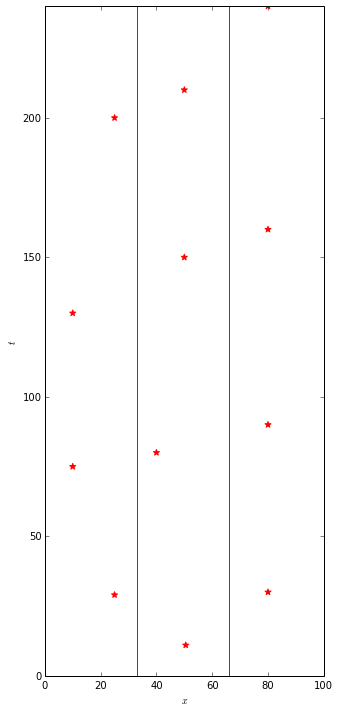

In [16]:
uniform_states = [[29, 25], [11, 50.5], [30, 80],[75, 10], [80, 40], [90, 80], [130, 10], [150, 50], [160, 80], 
                 [200, 25], [210, 50], [240, 80]]
sampled_events, signals = sample_signal_given_test_events(uniform_states)
visualize_samples(samples=None, true_events=sampled_events)

Done
Done
Done


/Library/Python/2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


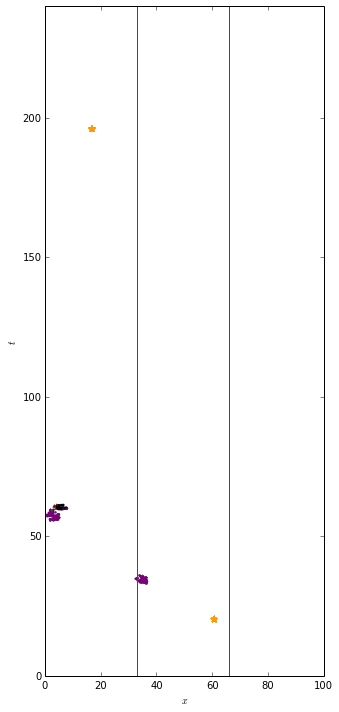

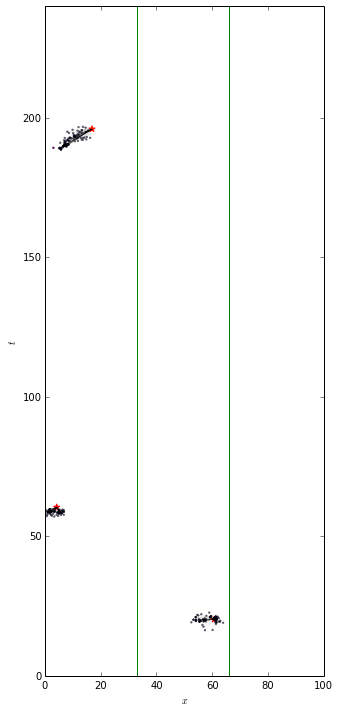

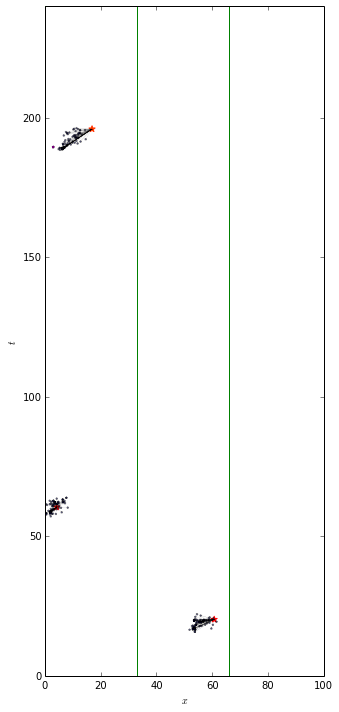

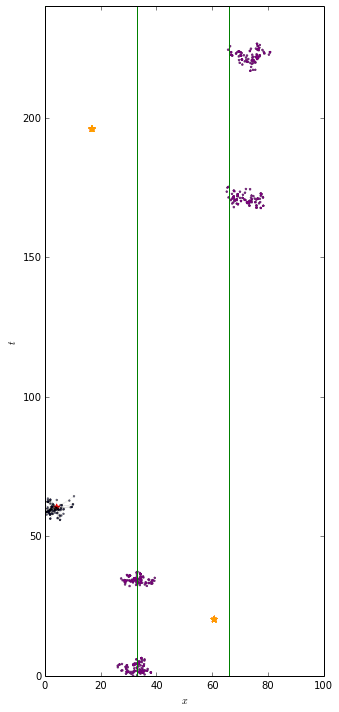

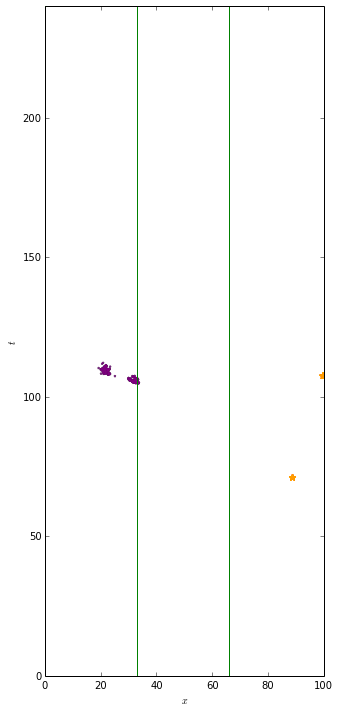

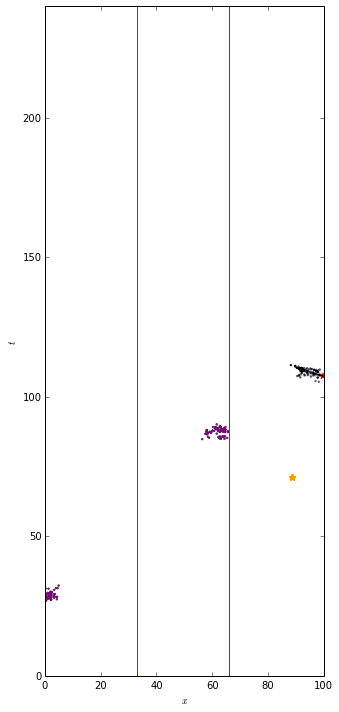

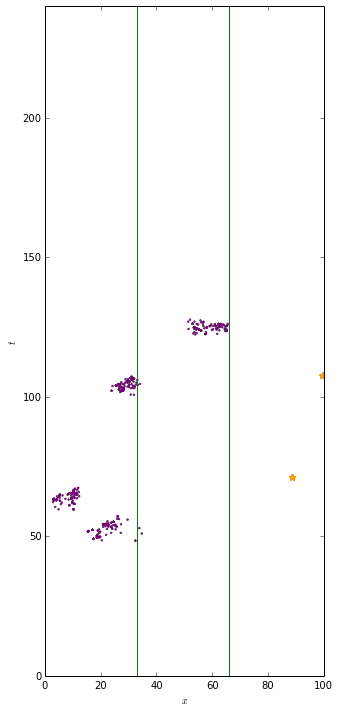

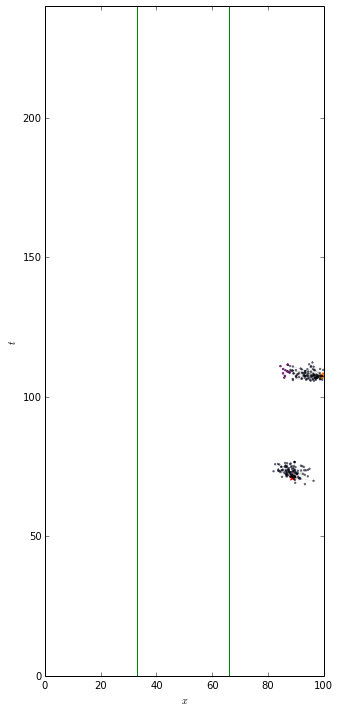

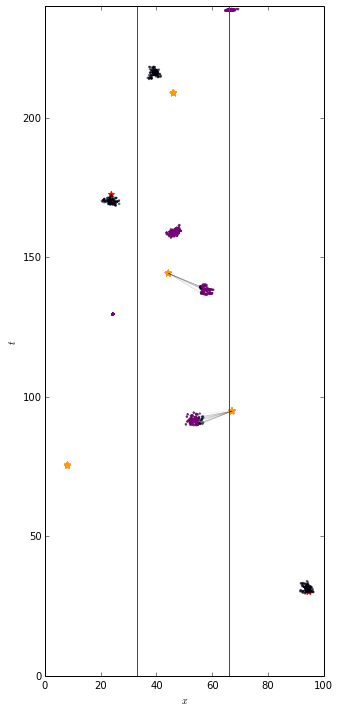

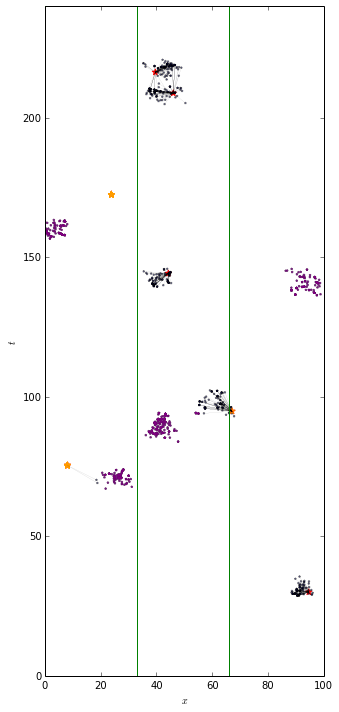

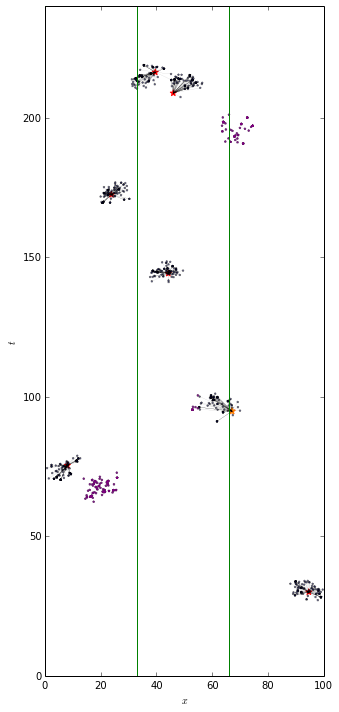

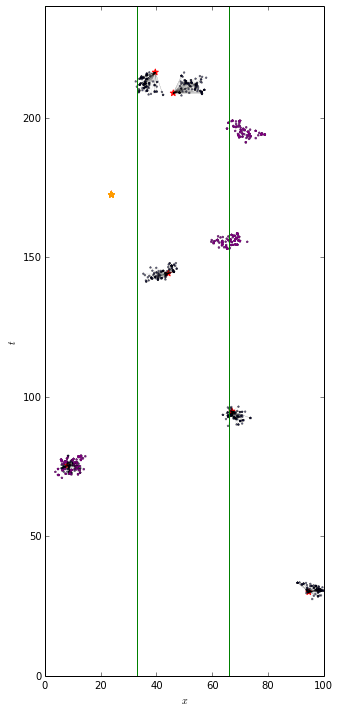

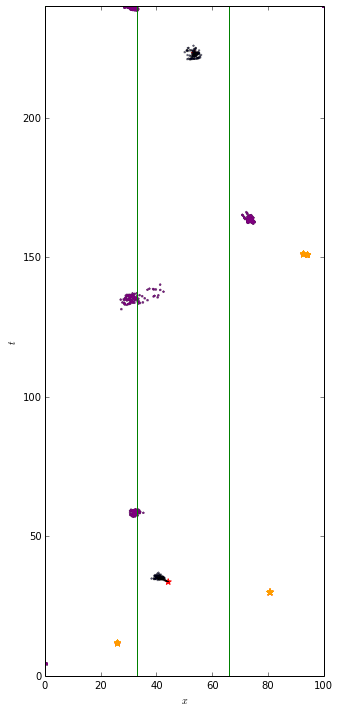

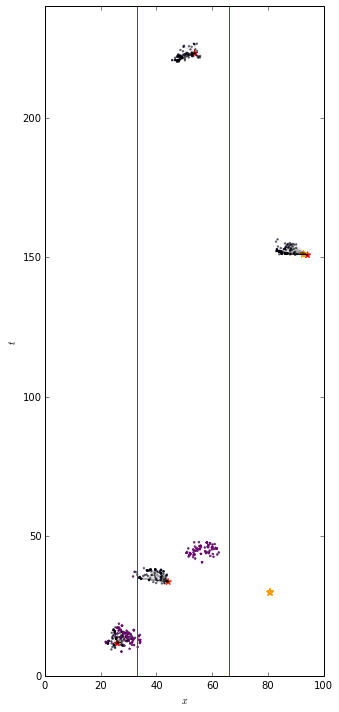

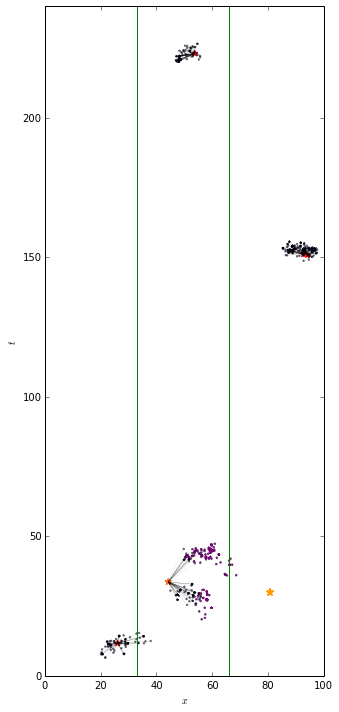

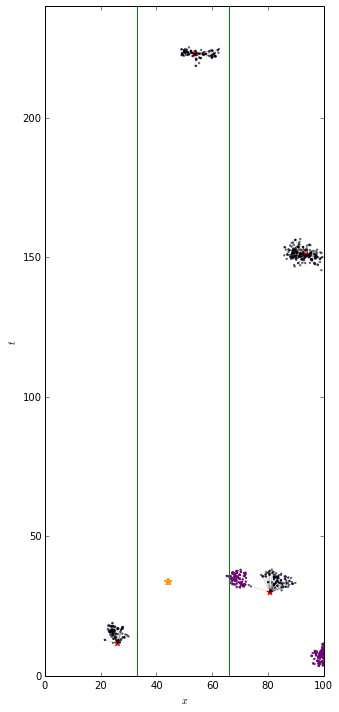

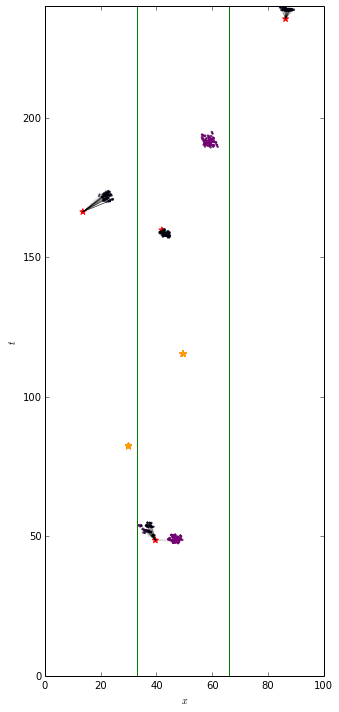

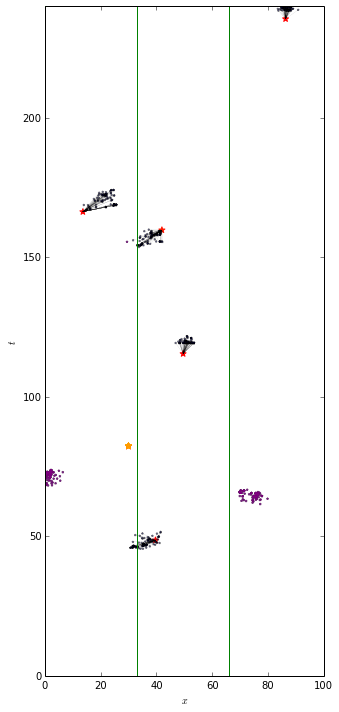

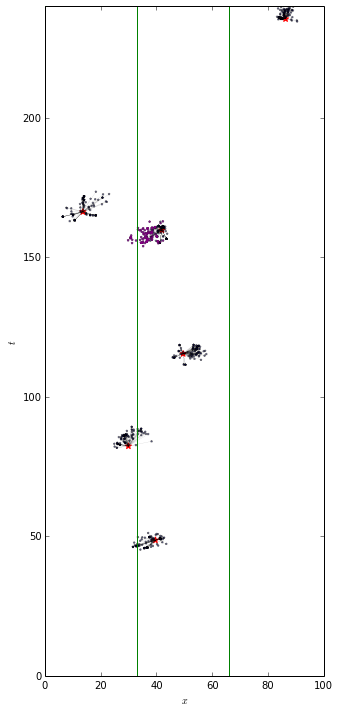

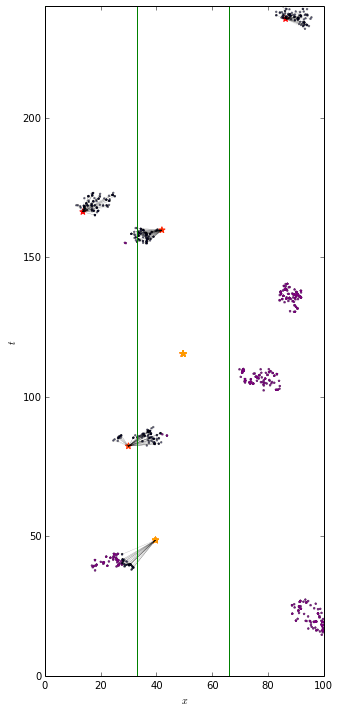

In [74]:
# graph is good when there exists event in each region and time diff is large

num_world = 5
naive_avg_err = np.zeros(np.shape(np.arange(0,200,0.5)))
naive_avg_prec = np.zeros(np.shape(np.arange(0,200,0.5)))
naive_avg_recall = np.zeros(np.shape(np.arange(0,200,0.5)))
naive_avg_lps = np.zeros(np.shape(np.arange(0,200,0.5)))

chrom_avg_err = np.zeros(np.shape(np.arange(0,200,0.5)))
chrom_avg_prec = np.zeros(np.shape(np.arange(0,200,0.5)))
chrom_avg_recall = np.zeros(np.shape(np.arange(0,200,0.5)))
chrom_avg_lps = np.zeros(np.shape(np.arange(0,200,0.5)))

dynamic_avg_err = np.zeros(np.shape(np.arange(0,200,0.5)))
dynamic_avg_prec = np.zeros(np.shape(np.arange(0,200,0.5)))
dynamic_avg_recall = np.zeros(np.shape(np.arange(0,200,0.5)))
dynamic_avg_lps = np.zeros(np.shape(np.arange(0,200,0.5)))

serial_avg_err = np.zeros(np.shape(np.arange(0,200,0.5)))
serial_avg_prec = np.zeros(np.shape(np.arange(0,200,0.5)))
serial_avg_recall = np.zeros(np.shape(np.arange(0,200,0.5)))
serial_avg_lps = np.zeros(np.shape(np.arange(0,200,0.5)))

for i in range(num_world):
    
    sampled_events, signals = sample_world_from_prior()
    
    
    all_samples_n, time_to_len_naive = inference_parallel_naive(signals, steps = 42500, check_points = 425)
    naive_err, naive_prec, naive_recall, naive_lps = plot_helper(time_to_len_naive, all_samples_n, sampled_events, signals)
    naive_avg_err = naive_avg_err + np.asarray(naive_err)/num_world
    naive_avg_prec = naive_avg_prec + np.asarray(naive_prec)/num_world
    naive_avg_recall = naive_avg_recall + np.asarray(naive_recall)/num_world
    naive_avg_lps = naive_avg_lps + np.asarray(naive_lps)/num_world
    print 'Done'

            
    
    all_samples_c, time_to_len_chrom = inference_parallel_chromatic_dynamic(signals, steps = 300, times = 315, period = sys.maxint) 
    chrom_err, chrom_prec, chrom_recall, chrom_lps = plot_helper(time_to_len_chrom, all_samples_c, sampled_events, signals)
    chrom_avg_err = chrom_avg_err + np.asarray(chrom_err)/num_world
    chrom_avg_prec = chrom_avg_prec + np.asarray(chrom_prec)/num_world 
    chrom_avg_recall = chrom_avg_recall + np.asarray(chrom_recall)/num_world 
    chrom_avg_lps = chrom_avg_lps + np.asarray(chrom_lps)/num_world
    print 'Done'



    all_samples_d, time_to_len_dynamic = inference_parallel_chromatic_dynamic(signals, steps = 300, times = 315, period = 2) 
    dynamic_err, dynamic_prec, dynamic_recall, dynamic_lps = plot_helper(time_to_len_dynamic, all_samples_d, sampled_events, signals)
    dynamic_avg_err = dynamic_avg_err + np.asarray(dynamic_err)/num_world
    dynamic_avg_prec = dynamic_avg_prec + np.asarray(dynamic_prec)/num_world 
    dynamic_avg_recall = dynamic_avg_recall + np.asarray(dynamic_recall)/num_world 
    dynamic_avg_lps = dynamic_avg_lps + np.asarray(dynamic_lps)/num_world
    
    print 'Done'


    
    mh_samples, time_to_len_serial = run_mh_w_multimoves(x0, signals, steps= 42500, check_points = 425)
    serial_err, serial_prec, serial_recall, serial_lps = plot_helper(time_to_len_serial, mh_samples, sampled_events, signals)
    serial_avg_err = serial_avg_err + np.asarray(serial_err)/num_world
    serial_avg_prec = serial_avg_prec + np.asarray(serial_prec)/num_world 
    serial_avg_recall = serial_avg_recall + np.asarray(serial_recall)/num_world 
    serial_avg_lps = serial_avg_lps + np.asarray(serial_lps)/num_world

    print 'Done'
    
    

In [73]:
def plot_helper(time_to_len, samples, sampled_events, signals):
    x_axis = np.arange(0,200,0.5)
    time = [item[0] for item in time_to_len]
    samples_len = [item[1] for item in time_to_len]
    recalls = []
    precisions = []
    errors = []
    lps = []
    for x in x_axis:
        time_diff = np.absolute(np.asarray(time) - x)
        min_diff_index = np.argmin(time_diff)
        length = samples_len[min_diff_index]
        predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(samples[:length], sampled_events)
        recalls.append(recall)
        precisions.append(precision)
        errors.append(error)
        lps.append(logp(samples[length], signals))
    visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, None)
    return errors, precisions, recalls, lps



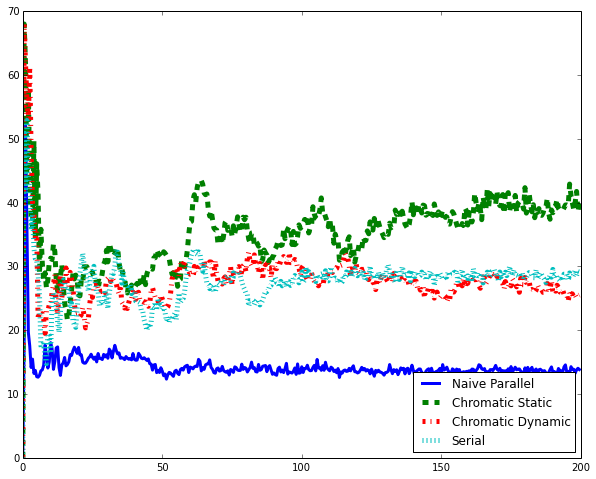

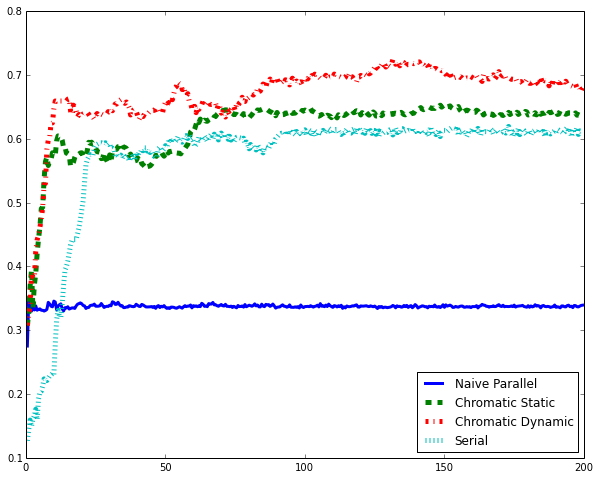

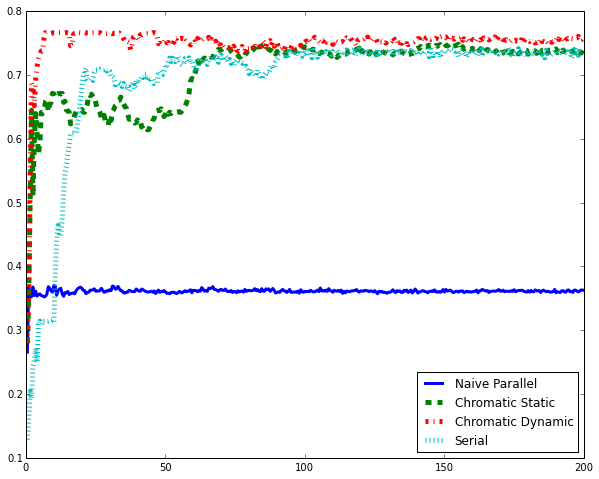

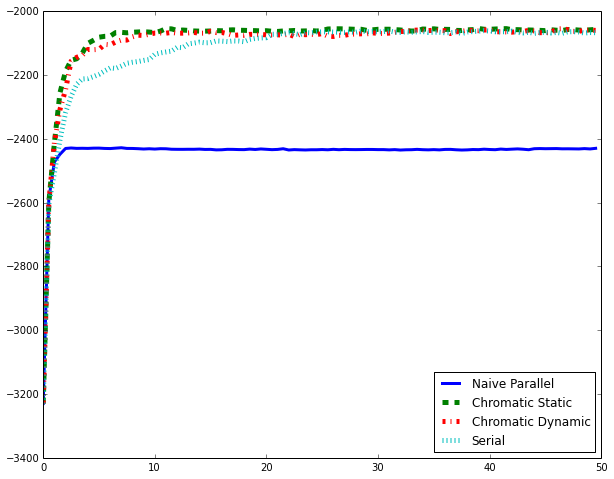

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

naive, = plt.plot(np.arange(0,200,0.5), naive_avg_err, color = 'b', label='Naive Parallel', ls = '-', lw = 3)
static, = plt.plot(np.arange(0,200,0.5), chrom_avg_err, color = 'g', label = 'Chromatic Static', ls= '--', lw = 5)
dynamic, = plt.plot(np.arange(0,200,0.5), dynamic_avg_err, color = 'r', label = 'Chromatic Dynamic', ls= '-.', lw = 5)
serial, = plt.plot(np.arange(0,200,0.5), serial_avg_err, color = 'c', label = 'Serial', ls = ":", lw = 5)
plt.legend(loc = 'lower right')

plt.figure(figsize=(10,8))


plt.plot(np.arange(0,200,0.5), naive_avg_prec, color = 'b', label='Naive Parallel', ls = '-', lw = 3)
plt.plot(np.arange(0,200,0.5), chrom_avg_prec, color = 'g', label = 'Chromatic Static',  ls= '--', lw = 5)
plt.plot(np.arange(0,200,0.5), dynamic_avg_prec, color = 'r', label = 'Chromatic Dynamic', ls= '-.', lw = 5)
plt.plot(np.arange(0,200,0.5), serial_avg_prec, color = 'c', label = 'Serial', ls = ":", lw = 5)
plt.legend(loc = 'lower right')

plt.figure(figsize=(10,8))

plt.plot(np.arange(0,200,0.5), naive_avg_recall, color = 'b', label='Naive Parallel', ls = '-', lw = 3)
plt.plot(np.arange(0,200,0.5), chrom_avg_recall, color = 'g', label = 'Chromatic Static', ls= '--', lw = 5)
plt.plot(np.arange(0,200,0.5), dynamic_avg_recall, color = 'r',label = 'Chromatic Dynamic', ls= '-.', lw = 5)
plt.plot(np.arange(0,200,0.5), serial_avg_recall, color = 'c',label = 'Serial', ls = ":", lw = 5)
plt.legend(loc = 'lower right')

plt.figure(figsize=(10,8))


plt.plot(np.arange(0,50,0.5), naive_avg_lps[:100], color = 'b', label='Naive Parallel', ls = '-', lw = 3)
plt.plot(np.arange(0,50,0.5), chrom_avg_lps[:100], color = 'g', label = 'Chromatic Static', ls= '--', lw = 5)
plt.plot(np.arange(0,50,0.5), dynamic_avg_lps[:100], color = 'r',label = 'Chromatic Dynamic', ls= '-.', lw = 5)
plt.plot(np.arange(0,50,0.5), serial_avg_lps[:100], color = 'c',label = 'Serial', ls = ":", lw = 5)

plt.legend(loc = 'lower right')

In [ ]:
for j in range(10): # 10*2 random worlds  
    performance_parallel_naive = [[]]*3
    performance_parallel_chrom = [[]]*3
    performance_parallel_rand = [[]]*3
    performance_serial = [[]]*3
    performance_serial2 = [[]]*3
    random_worlds = []
    signal_collections = []
    for i in range(1): 
        sampled_events, signals = sample_world_from_prior()
        random_worlds.append(sampled_events)
        signal_collections.append(signals)
        
        avg_error_naive = 0
        avg_precision_naive = 0
        avg_recall_naive = 0
        for j in range(5): # run each algorithm five times, get average performance 
            all_samples, tl = inference_parallel_naive(signals, steps = 10000) # totally 10000 * 4
            predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(all_samples, sampled_events)
#             visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, region_length)
            avg_error_naive += error/5.0
            avg_precision_naive += precision/5.0
            avg_recall_naive += recall/5.0
            print 'small done'
        print 'chunk done'
        performance_parallel_naive[0] = performance_parallel_naive[0] + [avg_error_naive]
        performance_parallel_naive[1] = performance_parallel_naive[1] + [avg_precision_naive]
        performance_parallel_naive[2] = performance_parallel_naive[2] + [avg_recall_naive]
        print avg_error_naive, avg_precision_naive, avg_recall_naive
        
        avg_error = 0
        avg_precision = 0
        avg_recall = 0
        for j in range(5): # run each algorithm five times, get average performance 
            all_samples, tl = inference_parallel_chromatic_dynamic(signals, steps = 500, times = 40, period = sys.maxint) # totally 500*40*~2
            predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(all_samples, sampled_events)
#             visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, region_length)
            avg_error += error/5.0
            avg_precision += precision/5.0
            avg_recall += recall/5.0
            print 'small done'
        print 'chunk done'
        performance_parallel_chrom[0] = performance_parallel_chrom[0] + [avg_error]
        performance_parallel_chrom[1] = performance_parallel_chrom[1] + [avg_precision]
        performance_parallel_chrom[2] = performance_parallel_chrom[2] + [avg_recall]
        print avg_error, avg_precision, avg_recall
        
    
        avg_error_bound = 0
        avg_precision_bound = 0
        avg_recall_bound = 0
        for j in range(5): # run each algorithm five times, get average performance 
            all_samples, t_l = inference_parallel_chromatic_dynamic(signals, steps = 500, times = 40, period = 2) # 500*40*~2
            predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(all_samples, sampled_events)
#             visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events)
            avg_error_bound += error/5.0
            avg_precision_bound += precision/5.0
            avg_recall_bound += recall/5.0
            print 'small done'
        print 'chunk done'
        performance_parallel_rand[0] = performance_parallel_rand[0] + [avg_error_bound]
        performance_parallel_rand[1] = performance_parallel_rand[1] + [avg_precision_bound]
        performance_parallel_rand[2] = performance_parallel_rand[2] + [avg_recall_bound]
        print avg_error_bound, avg_precision_bound, avg_recall_bound
       
        
    
        avg_error_serial = 0
        avg_precision_serial = 0
        avg_recall_serial = 0
        for j in range(5): # run each algorithm five times, get average performance 
            mh_samples, t_l = run_mh_w_multimoves(x0, signals, steps= 40000)
            predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(mh_samples, sampled_events)
#             visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, None)
            avg_error_serial += error/5.0
            avg_precision_serial += precision/5.0
            avg_recall_serial += recall/5.0
            print 'small done'
        print 'chunk done'
        performance_serial[0] = performance_serial[0] + [avg_error_serial]
        performance_serial[1] = performance_serial[1] + [avg_precision_serial]
        performance_serial[2] = performance_serial[2] + [avg_recall_serial]
        print avg_error_serial, avg_precision_serial, avg_recall_serial
        
        
        
    f = open("parallel_error_n.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_naive[0]))
    f.close()

    f = open("parallel_precision_n.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_naive[1]))
    f.close()

    f = open("parallel_recall_n.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_naive[2]))
    f.close()
    
    f = open("parallel_error_c.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_chrom[0]))
    f.close()

    f = open("parallel_precision_c.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_chrom[1]))
    f.close()

    f = open("parallel_recall_c.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_chrom[2]))
    f.close()

    f = open("parallel_error_r.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_rand[0]))
    f.close()

    f = open("parallel_precision_r.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_rand[1]))
    f.close()

    f = open("parallel_recall_r.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_rand[2]))
    f.close()

    f = open("serial_error.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_serial[0]))
    f.close()

    f = open("serial_precision.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_serial[1]))
    f.close()

    f = open("serial_recall.txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_serial[2]))
    f.close()
    
#     f = open("serial_error2.txt", "a")
#     f.write("\n")
#     f.write("\n".join(str(x) for x in performance_serial2[0]))
#     f.close()

#     f = open("serial_precision2.txt", "a")
#     f.write("\n")
#     f.write("\n".join(str(x) for x in performance_serial2[1]))
#     f.close()

#     f = open("serial_recall2.txt", "a")
#     f.write("\n")
#     f.write("\n".join(str(x) for x in performance_serial2[2]))
#     f.close()


small done
small done
small done
small done
small done
chunk done
69.0728913819 0.404666666667 0.693714285714
small done
small done
small done
small done


# Mean and Bar Graphs

Bootstrapped 95% confidence intervals (Serial Error) 
Low: 25.3267844094 
High: 33.0704148623
('serial error mean', 29.886251834550002)


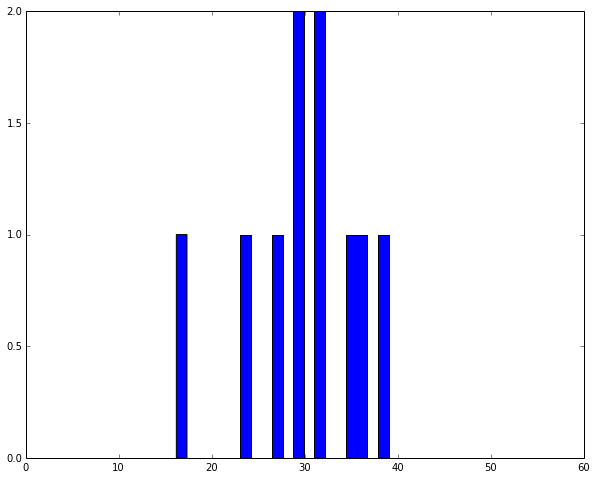

Bootstrapped 95% confidence intervals (Naive Parallel Error) 
Low: 24.2249329287 
High: 51.9186115868
('naive parallel error mean', 37.102222324924995)


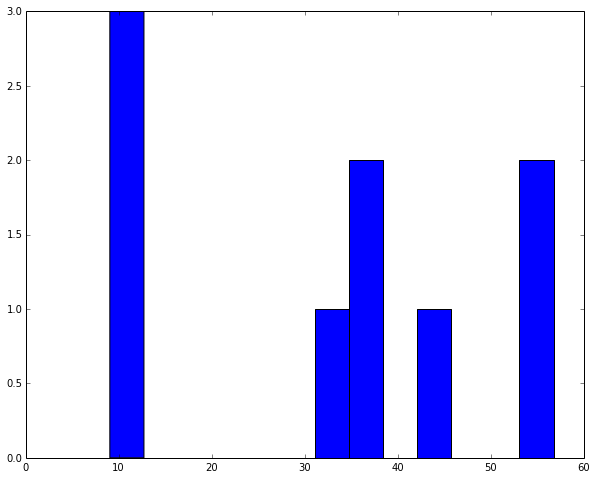

Bootstrapped 95% confidence intervals (Chromatic Parallel Error) 
Low: 19.2059198278 
High: 40.1445737784
('chromatic parallel error mean', 31.033248562894006)


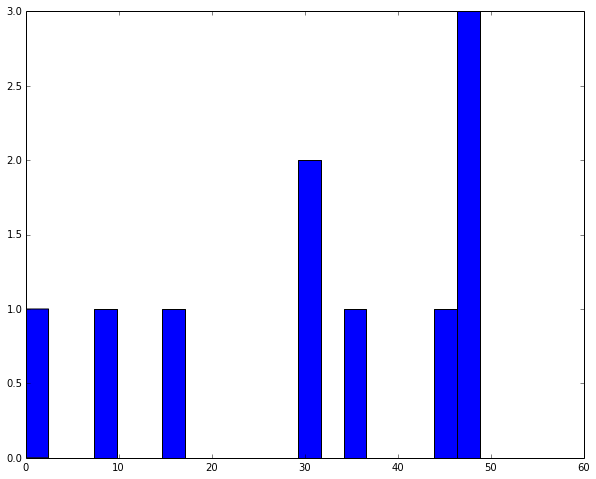

Bootstrapped 95% confidence intervals (Chromatic Dynamic Parallel Error) 
Low: 25.5408654365 
High: 35.3291484925
('parallel with dynamic coloring error mean', 29.918657913959997)


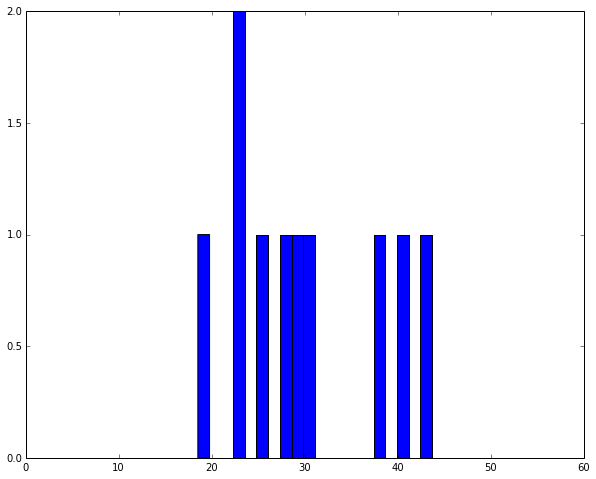

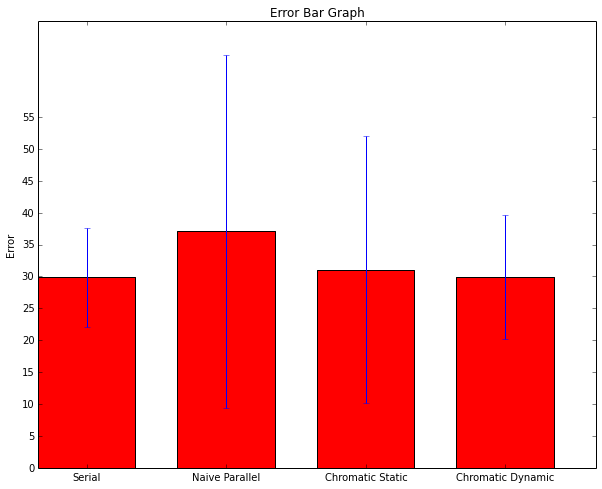

Bootstrapped 95% confidence intervals (Serial Precision) 
Low: 0.607781111111 
High: 0.722491652237
('serial precision mean', 0.67793324675319999)


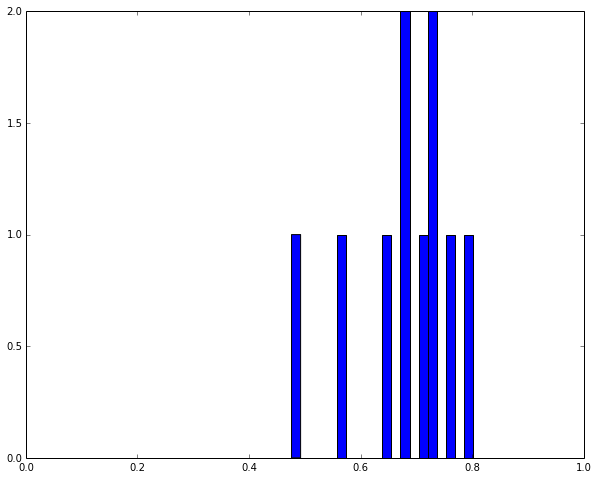

Bootstrapped 95% confidence intervals (Naive Parallel Precision) 
Low: 0.234863333333 
High: 0.426193333333
('naive parallel precision mean', 0.34545452380950004)


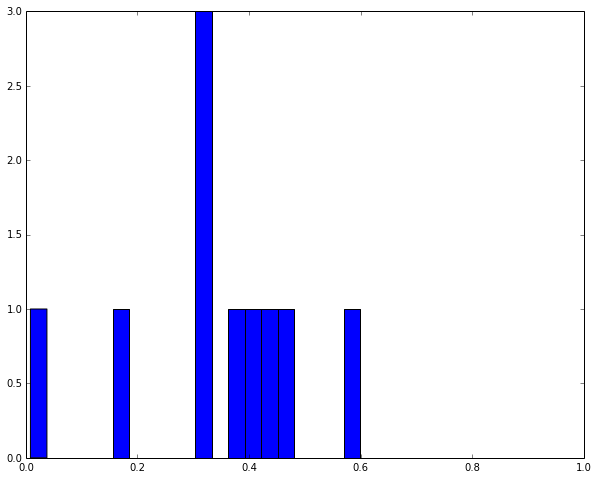

Bootstrapped 95% confidence intervals (Chromatic Parallel Precision) 
Low: 0.318797777778 
High: 0.71398984127
('chromatic parallel precision mean', 0.52457269841270004)


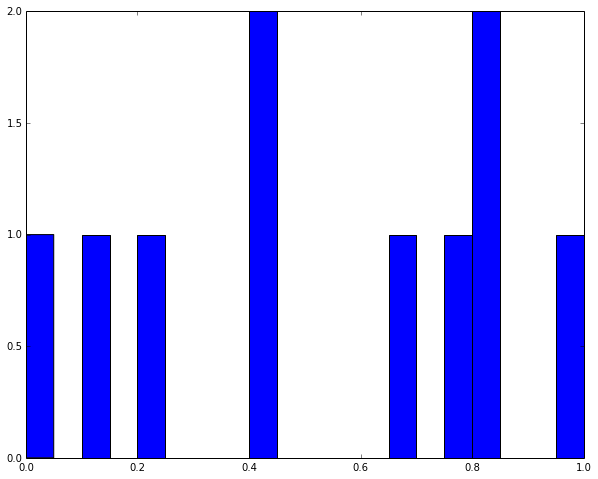

Bootstrapped 95% confidence intervals (Chromatic Dynamic Parallel Precision) 
Low: 0.479201428571 
High: 0.771821984127
('parallel with dynamic coloring precision mean',)


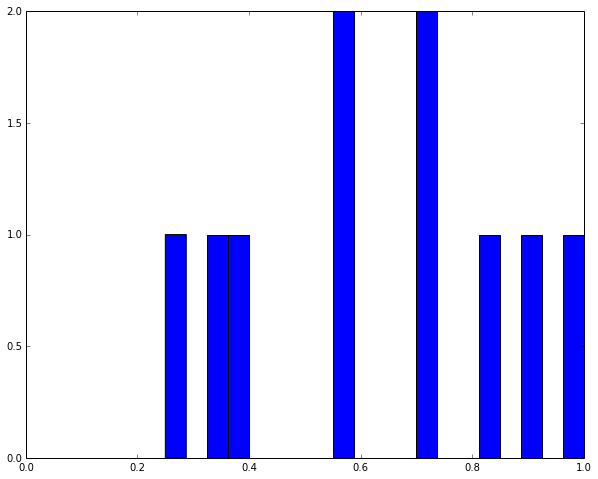

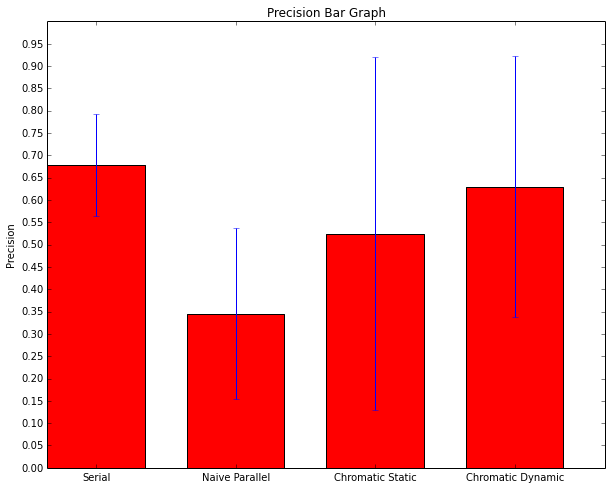

Bootstrapped 95% confidence intervals (Serial Recall) 
Low: 0.730796666667 
High: 0.84638
('serial recall mean', 0.79519666666669997)


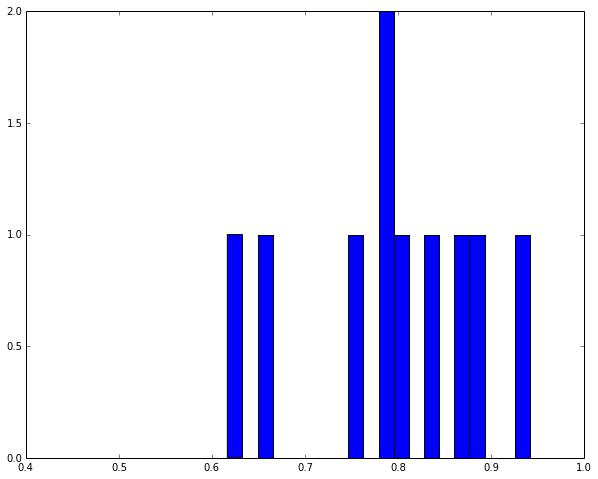

Bootstrapped 95% confidence intervals (Naive Parallel Recall) 
Low: 0.34861 
High: 0.680716666667
('naive parallel recall mean', 0.52930333333339996)


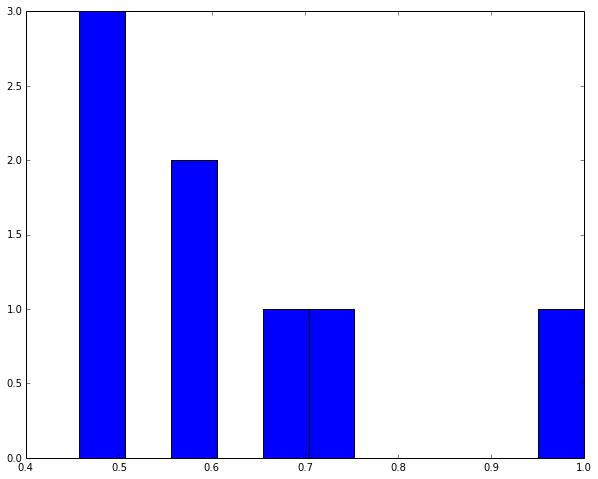

Bootstrapped 95% confidence intervals (Chromatic Parallel Recall) 
Low: 0.374666666667 
High: 0.784833333333
('chromatic parallel recall mean', 0.58816666666670003)


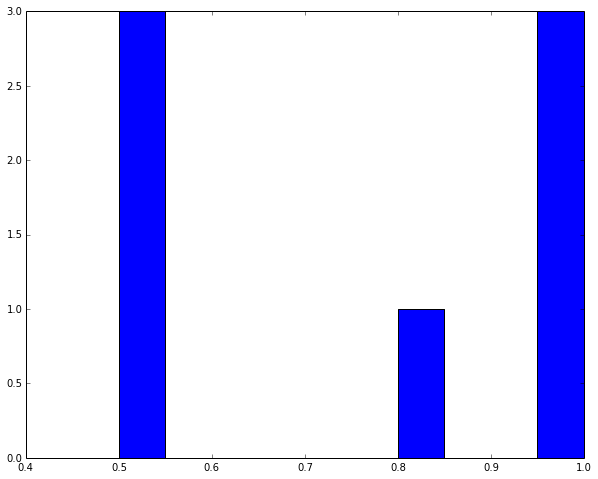

Bootstrapped 95% confidence intervals (Chromatic Dynamic Parallel Recall) 
Low: 0.593333333333 
High: 0.850391666667
('parallel with dynamic coloring recall mean', 0.74037833333330005)


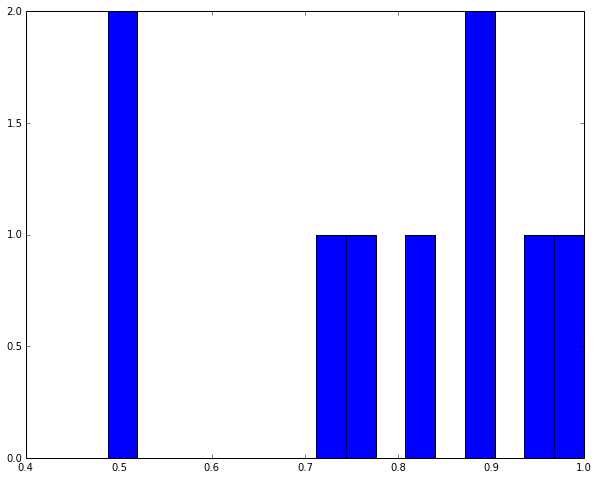

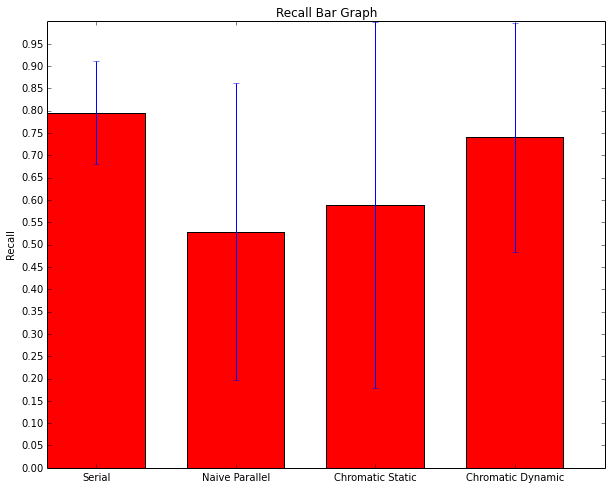

In [17]:
import matplotlib.pyplot as plt
import scipy  
import scikits.bootstrap as bootstrap  
import math
import numpy as np
import matplotlib.pyplot as plt

f = open("serial_error.txt", "r")
serial_error_lst = f.readlines()[1:]
serial_error = [float(i.split("\n")[0]) for i in serial_error_lst]
serial_err_CIs = bootstrap.ci(data=serial_error, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Serial Error) \nLow:", serial_err_CIs[0], "\nHigh:", serial_err_CIs[1]  
serial_err_mean = mean(serial_error)

print('serial error mean', serial_err_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(serial_error, bins=20)
plt.xlim(0, 60)
plt.show()
fig.suptitle('serial error histogram', fontsize=20)
fig.savefig('serial_error_hist.png')


f = open("parallel_error_n.txt", "r")
parallel_error_n_lst = f.readlines()[1:]
parallel_error_n = [float(i.split("\n")[0]) for i in parallel_error_n_lst]
naive_err_CIs = bootstrap.ci(data=parallel_error_n, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Naive Parallel Error) \nLow:", naive_err_CIs[0], "\nHigh:", naive_err_CIs[1]  
naive_err_mean = mean(parallel_error_n)

print('naive parallel error mean', naive_err_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(parallel_error_n, bins=20)
plt.xlim(0, 60)
plt.show()
fig.suptitle('naive parallel error histogram', fontsize=20)
fig.savefig('parallel_error_n_hist.png')


f = open("parallel_error_c.txt", "r")
parallel_error_lst = f.readlines()[1:]
parallel_error = [float(i.split("\n")[0]) for i in parallel_error_lst]
chrom_err_CIs = bootstrap.ci(data=parallel_error, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Chromatic Parallel Error) \nLow:", chrom_err_CIs[0], "\nHigh:", chrom_err_CIs[1]  
chrom_err_mean = mean(parallel_error)

print('chromatic parallel error mean', chrom_err_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(parallel_error, bins=20)
plt.xlim(0, 60)
plt.show()
fig.suptitle('chromatic parallel error histogram', fontsize=20)
fig.savefig('parallel_error_c_hist.png')


f = open("parallel_error_r.txt", "r")
parallel_error_b_lst = f.readlines()[1:]
parallel_error_b = [float(i.split("\n")[0]) for i in parallel_error_b_lst]
dynamic_err_CIs = bootstrap.ci(data=parallel_error_b, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Chromatic Dynamic Parallel Error) \nLow:", dynamic_err_CIs[0], "\nHigh:", dynamic_err_CIs[1]  
dynamic_err_mean = mean(parallel_error_b)

print('parallel with dynamic coloring error mean', dynamic_err_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(parallel_error_b, bins=20)
plt.xlim(0, 60)
plt.show()
fig.suptitle('parallel with dynamic coloring error histogram', fontsize=20)
fig.savefig('parallel_error_r_hist.png')


N = 4
Means = (serial_err_mean, naive_err_mean, chrom_err_mean, dynamic_err_mean)
Std = (serial_err_CIs[1]-serial_err_CIs[0], naive_err_CIs[1]-naive_err_CIs[0], chrom_err_CIs[1]-chrom_err_CIs[0], \
      dynamic_err_CIs[1]-dynamic_err_CIs[0])
ind = np.arange(N)*0.5    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize=(10,8))
p1 = plt.bar(ind, Means, width, color='r', yerr=Std, ecolor = 'b')

plt.ylabel('Error')
plt.title('Error Bar Graph')
plt.xticks(ind + width/2., ('Serial', 'Naive Parallel', 'Chromatic Static', 'Chromatic Dynamic'))
plt.yticks(np.arange(0, 60, 5))
fig.savefig('err_bar.png')

plt.show()

###########
f = open("serial_precision.txt", "r")
serial_precision_lst = f.readlines()[1:]
serial_precision = [float(i.split("\n")[0]) for i in serial_precision_lst]
serial_prec_CIs = bootstrap.ci(data=serial_precision, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Serial Precision) \nLow:", serial_prec_CIs[0], "\nHigh:", serial_prec_CIs[1]
serial_prec_mean = mean(serial_precision)
# compute 95% confidence intervals around the mean  
 

print('serial precision mean', serial_prec_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(serial_precision, bins = 20)
plt.xlim(0, 1)
plt.show()
fig.suptitle('serial precision histogram', fontsize=20)
fig.savefig('serial_precision_hist.png')

f = open("parallel_precision_n.txt", "r")
parallel_precision_n_lst = f.readlines()[1:]
parallel_precision_n = [float(i.split("\n")[0]) for i in parallel_precision_n_lst]
naive_prec_CIs = bootstrap.ci(data=parallel_precision_n, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Naive Parallel Precision) \nLow:", naive_prec_CIs[0], "\nHigh:", naive_prec_CIs[1]
naive_prec_mean = mean(parallel_precision_n)

print('naive parallel precision mean', naive_prec_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(parallel_precision_n, bins = 20)
plt.xlim(0, 1)
plt.show()
fig.suptitle('naive parallel precision histogram', fontsize=20)
fig.savefig('parallel_precision_n_hist.png')

f = open("parallel_precision_c.txt", "r")
parallel_precision_lst = f.readlines()[1:]
parallel_precision = [float(i.split("\n")[0]) for i in parallel_precision_lst]
chrom_prec_CIs = bootstrap.ci(data=parallel_precision, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Chromatic Parallel Precision) \nLow:", chrom_prec_CIs[0], "\nHigh:", chrom_prec_CIs[1]
chrom_prec_mean = mean(parallel_precision)

print('chromatic parallel precision mean', chrom_prec_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(parallel_precision, bins = 20)
plt.xlim(0, 1)
plt.show()
fig.suptitle('chromatic parallel precision histogram', fontsize=20)
fig.savefig('parallel_precision_c_hist.png')


f = open("parallel_precision_r.txt", "r")
parallel_precision_b_lst = f.readlines()[1:]
parallel_precision_b = [float(i.split("\n")[0]) for i in parallel_precision_b_lst]
dynamic_prec_CIs = bootstrap.ci(data=parallel_precision_b, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Chromatic Dynamic Parallel Precision) \nLow:", dynamic_prec_CIs[0], "\nHigh:", dynamic_prec_CIs[1]
dynamic_prec_mean = mean(parallel_precision_b)

print('parallel with dynamic coloring precision mean', )
fig = plt.figure(figsize=(10,8))
plt.hist(parallel_precision_b,  bins= 20)
plt.xlim(0, 1)
plt.show()
fig.suptitle('parallel with dynamic coloring precision histogram', fontsize=20)
fig.savefig('parallel_precision_r_hist.png')


N = 4
Means = (serial_prec_mean, naive_prec_mean, chrom_prec_mean, dynamic_prec_mean)
Std = (serial_prec_CIs[1]-serial_prec_CIs[0], naive_prec_CIs[1]-naive_prec_CIs[0], chrom_prec_CIs[1]-chrom_prec_CIs[0], \
      dynamic_prec_CIs[1]-dynamic_prec_CIs[0])
ind = np.arange(N)*0.5   # the x locations for the groups
width = 0.35      # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize=(10,8))
p1 = plt.bar(ind, Means, width, color='r', yerr=Std, ecolor = 'b')

plt.ylabel('Precision')
plt.title('Precision Bar Graph')
plt.xticks(ind + width/2., ('Serial', 'Naive Parallel', 'Chromatic Static', 'Chromatic Dynamic'))
plt.yticks(np.arange(0, 1, 0.05))
fig.savefig('prec_bar.png')

plt.show()
##########
f = open("serial_recall.txt", "r")
serial_recall_lst = f.readlines()[1:]
serial_recall = [float(i.split("\n")[0]) for i in serial_recall_lst]
serial_recall_CIs = bootstrap.ci(data=serial_recall, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Serial Recall) \nLow:", serial_recall_CIs[0], "\nHigh:", serial_recall_CIs[1]
serial_recall_mean =  mean(serial_recall)

print('serial recall mean', serial_recall_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(serial_recall, bins = 20)
plt.xlim(0.4, 1)
plt.show()
fig.suptitle('serial recall histogram', fontsize=20)
fig.savefig('serial_recall_hist.png')


f = open("parallel_recall_n.txt", "r")
parallel_recall_n_lst = f.readlines()[1:]
parallel_recall_n = [float(i.split("\n")[0]) for i in parallel_recall_n_lst]
naive_recall_CIs = bootstrap.ci(data=parallel_recall_n, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Naive Parallel Recall) \nLow:", naive_recall_CIs[0], "\nHigh:", naive_recall_CIs[1]
naive_recall_mean = mean(parallel_recall_n)

print('naive parallel recall mean', naive_recall_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(parallel_recall_n, bins = 20)
plt.xlim(0.4, 1)
plt.show()
fig.suptitle('naive parallel recall histogram', fontsize=20)
fig.savefig('parallel_recall_n_hist.png')

f = open("parallel_recall_c.txt", "r")
parallel_recall_lst = f.readlines()[1:]
parallel_recall = [float(i.split("\n")[0]) for i in parallel_recall_lst]
chrom_recall_CIs = bootstrap.ci(data=parallel_recall, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Chromatic Parallel Recall) \nLow:", chrom_recall_CIs[0], "\nHigh:", chrom_recall_CIs[1]
chrom_recall_mean = mean(parallel_recall)

print('chromatic parallel recall mean', chrom_recall_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(parallel_recall, bins = 20)
plt.xlim(0.4, 1)
plt.show()
fig.suptitle('chromatic parallel recall histogram', fontsize=20)
fig.savefig('parallel_recall_c_hist.png')


f = open("parallel_recall_r.txt", "r")
parallel_recall_b_lst = f.readlines()[1:]
parallel_recall_b = [float(i.split("\n")[0]) for i in parallel_recall_b_lst]
dynamic_recall_CIs = bootstrap.ci(data=parallel_recall_b, statfunction=scipy.mean)  
print "Bootstrapped 95% confidence intervals (Chromatic Dynamic Parallel Recall) \nLow:", dynamic_recall_CIs[0], "\nHigh:", dynamic_recall_CIs[1]
dynamic_recall_mean = mean(parallel_recall_b)

print('parallel with dynamic coloring recall mean', dynamic_recall_mean)
fig = plt.figure(figsize=(10,8))
plt.hist(parallel_recall_b,  bins=20)
plt.xlim(0.4, 1)
plt.show() 
fig.suptitle('parallel with idynamic coloring recall histogram', fontsize=20)
fig.savefig('parallel_recall_r_hist.png')

N = 4
Means = (serial_recall_mean, naive_recall_mean, chrom_recall_mean, dynamic_recall_mean)
Std = (serial_recall_CIs[1]-serial_recall_CIs[0], naive_recall_CIs[1]-naive_recall_CIs[0], chrom_recall_CIs[1]-chrom_recall_CIs[0], \
      dynamic_recall_CIs[1]-dynamic_recall_CIs[0])
ind = np.arange(N)*0.5    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize=(10,8))
p1 = plt.bar(ind, Means, width, color='r', yerr=Std, ecolor = 'b')

plt.ylabel('Recall')
plt.title('Recall Bar Graph')
plt.xticks(ind + width/2., ('Serial', 'Naive Parallel', 'Chromatic Static', 'Chromatic Dynamic'))
plt.yticks(np.arange(0, 1, 0.05))
fig.savefig('recall_bar.png')

plt.show()

## Test on arbitrary world

In [ ]:
blue, red, blue_region_num, red_region_num, region_length = build_region()

empty_states = [];
empty_events, empty_signals = sample_signal_given_test_events(empty_states)
# visualize_samples(samples=None, true_events=None)
# visualize_signals(empty_events, empty_signals)

boundary_states = [[region_length+1, 10],[region_length-1, 20],[region_length*2+1, 30],\
                   [region_length*2-1, 40],[region_length*3+1, 50], [region_length*4-1, 70]]
boundary_events, boundary_signals = sample_signal_given_test_events(boundary_states)
# visualize_samples(samples=None, true_events=boundary_events)
# visualize_signals(boundary_events, boundary_signals)

middle_states = [[0.5*region_length, 10],[0.5*region_length, 20],[1.5*region_length,30],\
                 [1.5*region_length, 50],[2.5*region_length, 90], [3.5*region_length,20],\
                [3.5*region_length, 85]]
middle_events, middle_signals = sample_signal_given_test_events(middle_states)
# visualize_samples(samples=None, true_events=middle_events)
# visualize_signals(middle_events, middle_signals)


same_arrival_states = [[30, 13],[40,33],[100,83],[125,33]]
same_arr_events, same_arr_signals = sample_signal_given_test_events(same_arrival_states)

flip_states = [[205, 55], [220, 62]]
flip_events, flip_signals = sample_signal_given_test_events(flip_states)
visualize_samples(samples=None, true_events=flip_events)
visualize_signals(flip_events, flip_signals)

# flip4_states = [[214.25, 73.5], [210.75, 43.5]]
# flip4_events, flip4_signals = sample_signal_given_test_events(flip4_states)
# visualize_samples(samples=None, true_events=flip4_events)

# flip3_states = [[39, 34], [67.5, 45]] 
# flip3_events, flip3_signals = sample_signal_given_test_events(flip3_states)
# visualize_samples(samples=None, true_events=flip3_events)


flip5_states = [[56, 68], [50.5, 11]]
flip5_events, flip5_signals = sample_signal_given_test_events(flip5_states)
visualize_samples(samples=None, true_events=flip5_events)

flip6_states = [[32.95379025,  50.1900373],
 [246.47309256, 52.66554262],
 [171.25711084, 17.92322342],
 [230.63261445, 48.21758338],
 [0.48724663, 30.34503874]]
flip6_events, flip6_signals = sample_signal_given_test_events(flip6_states)
visualize_samples(samples=None, true_events=flip6_events)

In [ ]:
sampled_events = flip6_events
signals = flip6_signals

# avg_error = 0
# avg_precision = 0
# avg_recall = 0
# for j in range(2): # run each algorithm five times, get average performance 
#     all_samples, region_samples, region_lps = inference_parallel(signals, steps = 500, times = 20)
#     predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate_parallel(region_samples, region_lps, sampled_events)
#     avg_error += error/10.0
#     avg_precision += precision/
#     avg_recall += recall/10.0
#     print 'small done'
# print 'chunk done'
# print avg_error, avg_precision, avg_recall
# visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, region_length)

# avg_error_bound = 0
# avg_precision_bound = 0
# avg_recall_bound = 0
# for j in range(10): # run each algorithm five times, get average performance 
#     all_samples_bound, region_samples_bound, region_lps_bound = inference_parallel_bound(signals, steps = 500, times = 20)
#     predictions_bound, matchings_bound, left_predictions_bound, left_true_events_bound, error_bound, precision_bound, recall_bound = performance_evaluate_parallel(region_samples_bound, region_lps_bound, sampled_events)
#     avg_error_bound += error_bound/10.0
#     avg_precision_bound += precision_bound/10.0
#     avg_recall_bound += recall_bound/10.0
#     print 'small done'
# print 'chunk done'
# print avg_error_bound, avg_precision_bound, avg_recall_bound
# visualize_prediction(predictions_bound, sampled_events, matchings_bound, left_predictions_bound, left_true_events_bound, region_length)
    
#makes them confused, start from false matching, below is false matching of flip_states above
# x0_states = 
# x0, x0_signals = sample_signal_given_test_events(x0_states)

x0 = np.zeros((0, 0)) 

avg_error_serial = 0
avg_precision_serial = 0
avg_recall_serial = 0
for j in range(3): # run each algorithm five times, get average performance 
    mh_samples, mh_lps = run_mh(x0, signals, steps=50000)
    predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(mh_samples, sampled_events)
    avg_error_serial += error/3.0
    avg_precision_serial += precision/3.0
    avg_recall_serial += recall/3.0
    visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, None)
    print 'small done'
print 'chunk done'
print avg_error_serial, avg_precision_serial, avg_recall_serial

avg_error_serial_new = 0
avg_precision_serial_new = 0
avg_recall_serial_new = 0
for j in range(3): # run each algorithm five times, get average performance 
    mh_samples, mh_lps = run_mh_w_multimoves(x0, signals, steps=50000)
    predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(mh_samples, sampled_events)
    avg_error_serial_new += error/3.0
    avg_precision_serial_new += precision/3.0
    avg_recall_serial_new += recall/3.0
    visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, None)
    print 'small done'
print 'chunk done'
print avg_error_serial_new, avg_precision_serial_new, avg_recall_serial_new
    


# 

### Boundary Test

In [ ]:
import random
blue, red, blue_region_num, red_region_num, proposal_stddev, out_of_bound_range, region_length = build_region()
region_num = blue_region_num + red_region_num
boundaries = []
for j in range(1, region_num):
    boundaries += [region_length*j]

for j in range(10): # 5*2 random worlds  
    performance_parallel = [[]]*3
    performance_parallel_bound = [[]]*3
    performance_parallel_naive = [[]]*3
    performance_serial = [[]]*3
    random_worlds = []
    signal_collections = []
    for i in range(1):
        event_num = random.randint(3, 6)  # 3 to 6 boundary events
        bound_states = []
        for j in range(event_num):
            rand_boundary = random.randint(0, len(boundaries)-1)
            t = boundaries[rand_boundary] + float(scipy.stats.uniform(0, 5).rvs(1))
            x = random.randint(xmin, xmax)
            bound_states.append([t, x])   # generate several boundary events

        bound_events, bound_signals = sample_signal_given_test_events(bound_states)
        sampled_events = bound_events
        signals = bound_signals
        
        
        avg_error_naive = 0
        avg_precision_naive = 0
        avg_recall_naive = 0
        for j in range(3): # run each algorithm five times, get average performance 
            all_samples, region_samples, region_lps = inference_parallel_naive(signals, steps = 10000) # totally 10000 * 4
            predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate_parallel(region_samples, region_lps, sampled_events)
            visualize_prediction(predictions, sampled_events, matchings, left_predictions, left_true_events, region_length)
            avg_error_naive += error/3.0
            avg_precision_naive += precision/3.0
            avg_recall_naive += recall/3.0
            print 'small done'
        print 'chunk done'
        performance_parallel_naive[0] = performance_parallel_naive[0] + [avg_error_naive]
        performance_parallel_naive[1] = performance_parallel_naive[1] + [avg_precision_naive]
        performance_parallel_naive[2] = performance_parallel_naive[2] + [avg_recall_naive]
        print avg_error_naive, avg_precision_naive, avg_recall_naive
        
        avg_error = 0
        avg_precision = 0
        avg_recall = 0
        for j in range(3): # run each algorithm five times, get average performance 
            all_samples, region_samples, region_lps = inference_parallel(signals, steps = 500, times = 20)
            predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate_parallel(region_samples, region_lps, sampled_events)
            avg_error += error/3.0
            avg_precision += precision/3.0
            avg_recall += recall/3.0
            print 'small done'
        print 'chunk done'
        performance_parallel[0] = performance_parallel[0] + [avg_error]
        performance_parallel[1] = performance_parallel[1] + [avg_precision]
        performance_parallel[2] = performance_parallel[2] + [avg_recall]
    
        avg_error_bound = 0
        avg_precision_bound = 0
        avg_recall_bound = 0
        for j in range(3): # run each algorithm five times, get average performance 
            all_samples_bound, region_samples_bound, region_lps_bound = inference_parallel_bound(signals, steps = 500, times = 20)
            predictions_bound, matchings_bound, left_predictions_bound, left_true_events_bound, error_bound, precision_bound, recall_bound = performance_evaluate_parallel(region_samples_bound, region_lps_bound, sampled_events)
            avg_error_bound += error_bound/3.0
            avg_precision_bound += precision_bound/3.0
            avg_recall_bound += recall_bound/3.0
            print 'small done'
        print 'chunk done'
        performance_parallel_bound[0] = performance_parallel_bound[0] + [avg_error_bound]
        performance_parallel_bound[1] = performance_parallel_bound[1] + [avg_precision_bound]
        performance_parallel_bound[2] = performance_parallel_bound[2] + [avg_recall_bound]
        
    
    
        avg_error_serial = 0
        avg_precision_serial = 0
        avg_recall_serial = 0
        for j in range(3): # run each algorithm five times, get average performance 
            mh_samples, mh_lps = run_mh(x0, signals, steps=50000)
            predictions, matchings, left_predictions, left_true_events, error, precision, recall = performance_evaluate(mh_samples, mh_lps, sampled_events)
            avg_error_serial += error/3.0
            avg_precision_serial += precision/3.0
            avg_recall_serial += recall/3.0
            print 'small done'
        print 'chunk done'
        performance_serial[0] = performance_serial[0] + [avg_error_serial]
        performance_serial[1] = performance_serial[1] + [avg_precision_serial]
        performance_serial[2] = performance_serial[2] + [avg_recall_serial]
 
    f = open("parallel_error_n(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_naive[0]))
    f.close()

    f = open("parallel_precision_n(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_naive[1]))
    f.close()

    f = open("parallel_recall_n(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_naive[2]))
    f.close()
    
    f = open("parallel_error(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel[0]))
    f.close()

    f = open("parallel_precision(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel[1]))
    f.close()

    f = open("parallel_recall(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel[2]))
    f.close()

    f = open("parallel_error_b(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_bound[0]))
    f.close()

    f = open("parallel_precision_b(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_bound[1]))
    f.close()

    f = open("parallel_recall_b(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_parallel_bound[2]))
    f.close()

    f = open("serial_error(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_serial[0]))
    f.close()

    f = open("serial_precision(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_serial[1]))
    f.close()

    f = open("serial_recall(boundary).txt", "a")
    f.write("\n")
    f.write("\n".join(str(x) for x in performance_serial[2]))
    f.close()

    

In [ ]:
import matplotlib.pyplot as plt

f = open("serial_error(boundary).txt", "r")
serial_error_lst = f.readlines()[1:]
serial_error = [float(i.split("\n")[0]) for i in serial_error_lst]

print('serial error mean', mean(serial_error))
fig = plt.figure()
plt.hist(serial_error, bins=40, range = (0, 500))
plt.show()
fig.suptitle('serial error histogram', fontsize=20)

f = open("parallel_error_n(boundary).txt", "r")
parallel_error_n_lst = f.readlines()[1:]
parallel_error_n = [float(i.split("\n")[0]) for i in parallel_error_n_lst]

print('naive parallel error mean', mean(parallel_error_n))
fig = plt.figure()
plt.hist(parallel_error_n, bins=40, range = (0, 500))
plt.show()
fig.suptitle('naive parallel error histogram', fontsize=20)

f = open("parallel_error(boundary).txt", "r")
parallel_error_lst = f.readlines()[1:]
parallel_error = [float(i.split("\n")[0]) for i in parallel_error_lst]

print('parallel error mean', mean(parallel_error))
fig = plt.figure()
plt.hist(parallel_error, bins=40, range = (0, 500))
plt.show()
fig.suptitle('parallel error histogram', fontsize=20)


f = open("parallel_error_b(boundary).txt", "r")
parallel_error_b_lst = f.readlines()[1:]
parallel_error_b = [float(i.split("\n")[0]) for i in parallel_error_b_lst]

print('parallel with intermediate regions error mean', mean(parallel_error_b))
fig = plt.figure()
plt.hist(parallel_error_b, bins=40, range = (0, 500))
plt.show()
fig.suptitle('parallel with intermediate regions error histogram', fontsize=20)

f = open("serial_precision(boundary).txt", "r")
serial_precision_lst = f.readlines()[1:]
serial_precision = [float(i.split("\n")[0]) for i in serial_precision_lst]

print('serial precision mean', mean(serial_precision))
fig = plt.figure()
plt.hist(serial_precision, bins = 40, range = (0,1))
plt.show()
fig.suptitle('serial precision histogram', fontsize=20)


f = open("parallel_precision_n(boundary).txt", "r")
parallel_precision_n_lst = f.readlines()[1:]
parallel_precision_n = [float(i.split("\n")[0]) for i in parallel_precision_n_lst]

print('naive parallel precision mean', mean(parallel_precision_n))
fig = plt.figure()
plt.hist(parallel_precision_n, bins = 40, range = (0,1))
plt.show()
fig.suptitle('naive parallel precision histogram', fontsize=20)

f = open("parallel_precision(boundary).txt", "r")
parallel_precision_lst = f.readlines()[1:]
parallel_precision = [float(i.split("\n")[0]) for i in parallel_precision_lst]

print('parallel precision mean', mean(parallel_precision))
fig = plt.figure()
plt.hist(parallel_precision, bins = 40, range = (0,1))
plt.show()
fig.suptitle('parallel precision histogram', fontsize=20)


f = open("parallel_precision_b(boundary).txt", "r")
parallel_precision_b_lst = f.readlines()[1:]
parallel_precision_b = [float(i.split("\n")[0]) for i in parallel_precision_b_lst]

print('parallel with intermediate regions precision mean', mean(parallel_precision_b))
fig = plt.figure()
plt.hist(parallel_precision_b,  bins=40, range = (0, 1))
plt.show()
fig.suptitle('parallel with intermediate regions precision histogram', fontsize=20)

f = open("serial_recall(boundary).txt", "r")
serial_recall_lst = f.readlines()[1:]
serial_recall = [float(i.split("\n")[0]) for i in serial_recall_lst]
print('serial recall mean', mean(serial_recall))

f = open("parallel_recall_n(boundary).txt", "r")
parallel_recall_n_lst = f.readlines()[1:]
parallel_recall_n = [float(i.split("\n")[0]) for i in parallel_recall_n_lst]
print('naive parallel recall mean', mean(parallel_recall_n))

f = open("parallel_recall(boundary).txt", "r")
parallel_recall_lst = f.readlines()[1:]
parallel_recall = [float(i.split("\n")[0]) for i in parallel_recall_lst]
print('parallel recall mean', mean(parallel_recall))

f = open("parallel_recall_b(boundary).txt", "r")
parallel_recall_b_lst = f.readlines()[1:]
parallel_recall_b = [float(i.split("\n")[0]) for i in parallel_recall_b_lst]
print('parallel with intermediate regions recall mean', mean(parallel_recall_b))


In [ ]:
# General Model: Gaussian Mixture, try Naive MCMC there
# Joint Move: move a_time at the same time

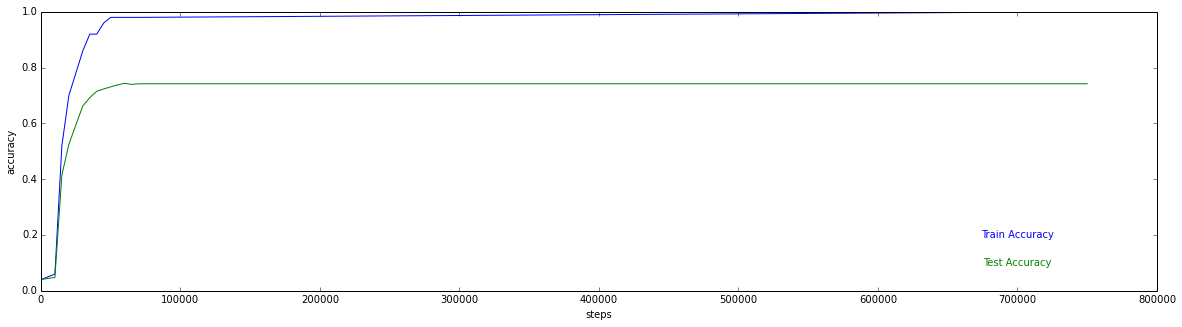

In [61]:
train_accuracy = [0.04, 0.06, 0.52, 0.7, 0.86, 0.92, 0.92, 0.96, 0.98, 0.98, 0.98, 0.98, 0.98, 1]
test_accuracy = [0.0405, 0.048, 0.415, 0.525, 0.66275, 0.69225, 0.71525, 0.7235, 0.731, 0.738, 0.74375, 0.73975, 0.742,  0.742]
steps = [0, 10000, 15000, 20000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 750000] # 10^4
plt.figure()

text(700000, 0.2,'Train Accuracy',
     horizontalalignment='center',
     verticalalignment='center',
     color = 'b')
text(700000, 0.1,'Test Accuracy',
     horizontalalignment='center',
     verticalalignment='center',
     color = 'g')
plt.plot(steps, train_accuracy, color = 'b')
plt.plot(steps, test_accuracy, color = 'g')
plt.xlabel('steps')
plt.ylabel('accuracy')